In [1]:
import os
import cv2
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torchvision

import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
from functions_v2 import(import_train_folder_dataset_2, 
                      Data_2, 
                      plot_loss_accuracy, 
                      accuracy_given_set,
                      import_test_folder_dataset_2,
                      Data_test_2,
                      make_predictions,
                      save_predictions_as_csv,
                      save_model,
                      save_metrics)

# 1. Build your own convolutional neural network using pytorch

In [4]:
# Learning parameters.
epochs = 500 # Number of epochs to train the model
lr = 0.01 # Learning rate.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 100 epochs


model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 1/CheckPoints/"

cuda


In [5]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        
        '''
        In dimension:              224 * 224 * 3 
        Out dimension Conv:        224 * 224 * 16
        Out dimension MaxPooling:  112 * 112 * 16
        '''
        self.cnn1_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        )
        self.cnn1_Res = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=1, stride=1, padding=0) 
        self.batch1 = nn.BatchNorm2d(16)
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
        
        
        '''
        In dimension:              112 * 112 * 16
        Out dimension Conv:        112 * 112 * 32
        Out dimension MaxPooling:  56  * 56  * 32
        '''
        self.cnn2_model = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        )
        self.cnn2_Res = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, stride=1, padding=0) 
        self.batch2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              56  * 56  * 32
        Out dimension Conv:        56  * 56  * 64
        Out dimension MaxPooling:  28  * 28  * 64
        '''
        self.cnn3_model = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        )
        self.cnn3_Res = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=1, padding=0) 
        self.batch3 = nn.BatchNorm2d(64)
        self.maxpool3 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              28  * 28  * 64
        Out dimension Conv:        28  * 28  * 128
        Out dimension MaxPooling:  7  * 7  * 128
        '''
        self.cnn4_model = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        )
        self.cnn4_Res = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=1, padding=0) 
        self.batch4 = nn.BatchNorm2d(128)
        self.maxpool4 = nn.MaxPool2d(4, stride=4)
        
        
        
        self.ffnn_model = nn.Sequential(
            nn.Linear(in_features=6272, out_features=512),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=4)
        )
        
        
        
    def forward(self, x): 
        
        residual = x
        # Convolution
        x = self.cnn1_model(x)
        # Residual
        residual = self.cnn1_Res(residual)
        x += residual
        x = self.batch1(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool1(x)
        
        
        residual = x
        # Convolution
        x = self.cnn2_model(x)
        # Residual
        residual = self.cnn2_Res(residual)
        x += residual
        x = self.batch2(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool2(x)
        
        
        residual = x
        # Convolution
        x = self.cnn3_model(x)
        # Residual
        residual = self.cnn3_Res(residual)
        x += residual
        x = self.batch3(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool3(x)
        
        
        residual = x
        # Convolution
        x = self.cnn4_model(x)
        # Residual
        residual = self.cnn4_Res(residual)
        x += residual
        x = self.batch4(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool4(x)
        
        
        x = torch.flatten(x,start_dim=1)
        #print("Flatten Out: ",x.shape)
        x = self.ffnn_model(x)
        #print("ffnn out: ",x.shape)
        x = torch.sigmoid(x)
        #print("Sigmoid Out: ",x.shape)
        return x


In [6]:
#PyTorch - Visualizing the Model
modelpy = ClassificationNet().to(device) # Get the model, and if there is a GPU use it
print("model created")
# Loss function.
criterion = nn.CrossEntropyLoss() # Set the loss function to cross entropy loss
# Optimizer.
optim = torch.optim.SGD(modelpy.parameters(), lr=lr)# , momentum=0.9, weight_decay=1e-3


# Check if checkpoint is available, if so, load it
epoch_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt.pth"):
        print("Loading save chackpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_check = checkpoint['epoch']
        criterion = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {epoch_check}")


modelpy

model created


ClassificationNet(
  (cnn1_model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (cnn1_Res): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_model): Sequential(
    (0): Conv2d(16, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (cnn2_Res): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3_model): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2

In [7]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 3723028


# Load Data

In [8]:
# Path of the files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Test"

In [9]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.Resize((275, 275)),
                                    #transforms.CenterCrop((224, 224)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [10]:
# Import the data into a resized 224x224 images
size_of_resized_img = (224,224) 
train_data, train_labels = import_train_folder_dataset_2(train_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", train_data.shape)
print("Dim of Lables: ", train_labels.shape)

Dim of Data:  (1149, 224, 224, 3)
Dim of Lables:  (1149,)


In [11]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 224, 224, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 224, 224, 3)
Dim of y_test:  (115,)


In [12]:
# Create the dataset object
train_Dataset = Data_2(X_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data_2(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [13]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

In [14]:
print("Type of object: ",type(train_loader))

print()
print( 'Train Size: ' + str(len(train_loader)))
print( 'Validate Size: ' + str(len(valid_loader)))

print()
print("Content of one element: ",iter(train_loader).next())

print()
print("Type of one element: ", type(iter(train_loader).next()))
print("Length of one element: ", len(iter(train_loader).next()))

print()
print('Input tensors size: ' + str(iter(train_loader).next()[0].shape)) # Input: 16, 16875 | 16 train batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(train_loader).next()[1].shape)) # Label: 16 | 16 train Batch size


print()
print('Input tensors size: ' + str(iter(valid_loader).next()[0].shape)) # Input: 8, 16875 | 8 validation batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(valid_loader).next()[1].shape)) # Label: 8 | 8 validation Batch size


Type of object:  <class 'torch.utils.data.dataloader.DataLoader'>

Train Size: 65
Validate Size: 15

Content of one element:  [tensor([[[[ 0.8618,  1.0159,  1.1015,  ..., -2.1179, -2.1179, -2.1179],
          [ 0.7419,  0.9474,  1.0673,  ..., -2.0494, -2.1179, -2.1179],
          [ 0.7762,  0.9474,  1.0502,  ..., -1.8610, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[ 1.1331,  1.2381,  1.2906,  ..., -2.0357, -2.0357, -2.0357],
          [ 1.0805,  1.2031,  1.2556,  ..., -1.9657, -2.0357, -2.0357],
          [ 1.1155,  1.2031,  1.2381,  ..., -1.7731, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.03

# 2. Train your model using cow teat datasets (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 


Epoch 1 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.07330428908364685
Val loss:  0.14544459011243738
train accuracy:  0.5174081237911026
Val accuracy:  0.6260869565217392
Current time: 4.998 minutes. Time expected till completion: 2493.953 minutes

Epoch 2 of 500


100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


train loss:  0.06999243141604115
Val loss:  0.1436128714810247
train accuracy:  0.5889748549323017
Val accuracy:  0.6434782608695652
Current time: 5.282 minutes. Time expected till completion: 1315.328 minutes

Epoch 3 of 500


100%|██████████| 15/15 [00:00<00:00, 15.92it/s]


train loss:  0.06879326585874797
Val loss:  0.14536398701045825
train accuracy:  0.6054158607350096
Val accuracy:  0.6521739130434783
Current time: 5.588 minutes. Time expected till completion: 925.762 minutes

Epoch 4 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.06894927623193545
Val loss:  0.14280160510021708
train accuracy:  0.5986460348162476
Val accuracy:  0.6521739130434783
Current time: 5.900 minutes. Time expected till completion: 731.647 minutes

Epoch 5 of 500


100%|██████████| 15/15 [00:00<00:00, 15.55it/s]


train loss:  0.06839054972798035
Val loss:  0.14297715010850326
train accuracy:  0.6121856866537717
Val accuracy:  0.6608695652173913
Current time: 6.210 minutes. Time expected till completion: 614.771 minutes

Epoch 6 of 500


100%|██████████| 15/15 [00:00<00:00, 16.02it/s]


train loss:  0.06839293500902113
Val loss:  0.1410099376802859
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 6.517 minutes. Time expected till completion: 536.547 minutes

Epoch 7 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06802369778114777
Val loss:  0.14291000210720559
train accuracy:  0.6218568665377177
Val accuracy:  0.6521739130434783
Current time: 6.830 minutes. Time expected till completion: 481.056 minutes

Epoch 8 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.06819902680367519
Val loss:  0.1416799669680388
train accuracy:  0.6112185686653772
Val accuracy:  0.6521739130434783
Current time: 7.143 minutes. Time expected till completion: 439.307 minutes

Epoch 9 of 500


100%|██████████| 15/15 [00:00<00:00, 15.90it/s]


train loss:  0.06794700389673908
Val loss:  0.14019871431848277
train accuracy:  0.6102514506769826
Val accuracy:  0.6695652173913044
Current time: 7.456 minutes. Time expected till completion: 406.755 minutes

Epoch 10 of 500


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


train loss:  0.067762783982537
Val loss:  0.13988810518513556
train accuracy:  0.6102514506769826
Val accuracy:  0.6608695652173913
Current time: 7.767 minutes. Time expected till completion: 380.592 minutes

Epoch 11 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.06762004204137644
Val loss:  0.1403350021528161
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 8.081 minutes. Time expected till completion: 359.233 minutes

Epoch 12 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.06767753417994575
Val loss:  0.1410566666851873
train accuracy:  0.6083172147001934
Val accuracy:  0.6695652173913044
Current time: 8.394 minutes. Time expected till completion: 341.350 minutes

Epoch 13 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.06753687459680052
Val loss:  0.14295396131017934
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 8.706 minutes. Time expected till completion: 326.139 minutes

Epoch 14 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.06762933955893526
Val loss:  0.1394867689713188
train accuracy:  0.6112185686653772
Val accuracy:  0.6608695652173913
Current time: 9.023 minutes. Time expected till completion: 313.216 minutes

Epoch 15 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06707235081283451
Val loss:  0.13941299656163092
train accuracy:  0.6121856866537717
Val accuracy:  0.6608695652173913
Current time: 9.334 minutes. Time expected till completion: 301.814 minutes

Epoch 16 of 500


100%|██████████| 15/15 [00:00<00:00, 16.82it/s]


train loss:  0.06704361099800242
Val loss:  0.14246584436167842
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 9.647 minutes. Time expected till completion: 291.833 minutes

Epoch 17 of 500


100%|██████████| 15/15 [00:00<00:00, 15.97it/s]


train loss:  0.06748576009757745
Val loss:  0.14036676469056503
train accuracy:  0.6170212765957447
Val accuracy:  0.6695652173913044
Current time: 9.962 minutes. Time expected till completion: 283.036 minutes

Epoch 18 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.06722661800956357
Val loss:  0.13968380378640216
train accuracy:  0.6150870406189555
Val accuracy:  0.6521739130434783
Current time: 10.275 minutes. Time expected till completion: 275.131 minutes

Epoch 19 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.06705050317415646
Val loss:  0.1419610215270001
train accuracy:  0.6150870406189555
Val accuracy:  0.6608695652173913
Current time: 10.587 minutes. Time expected till completion: 268.023 minutes

Epoch 20 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.06702867818985501
Val loss:  0.13821166857429174
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 10.898 minutes. Time expected till completion: 261.545 minutes

Epoch 21 of 500


100%|██████████| 15/15 [00:00<00:00, 17.03it/s]


train loss:  0.06717602300459458
Val loss:  0.13897243530853934
train accuracy:  0.6170212765957447
Val accuracy:  0.6695652173913044
Current time: 11.211 minutes. Time expected till completion: 255.708 minutes

Epoch 22 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.06722253889594824
Val loss:  0.14053760456002276
train accuracy:  0.6266924564796905
Val accuracy:  0.6608695652173913
Current time: 11.524 minutes. Time expected till completion: 250.389 minutes

Epoch 23 of 500


100%|██████████| 15/15 [00:00<00:00, 15.97it/s]


train loss:  0.06676642830182782
Val loss:  0.14056406280268793
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 11.838 minutes. Time expected till completion: 245.517 minutes

Epoch 24 of 500


100%|██████████| 15/15 [00:00<00:00, 16.17it/s]


train loss:  0.0672156285617061
Val loss:  0.13803229539290718
train accuracy:  0.6131528046421664
Val accuracy:  0.6608695652173913
Current time: 12.151 minutes. Time expected till completion: 241.002 minutes

Epoch 25 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.06696040055046229
Val loss:  0.13804267593052078
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 12.463 minutes. Time expected till completion: 236.797 minutes

Epoch 26 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.06649041752289526
Val loss:  0.14013132478879844
train accuracy:  0.632495164410058
Val accuracy:  0.6434782608695652
Current time: 12.775 minutes. Time expected till completion: 232.889 minutes

Epoch 27 of 500


100%|██████████| 15/15 [00:00<00:00, 17.11it/s]


train loss:  0.0665033872399616
Val loss:  0.1376942701961683
train accuracy:  0.6092843326885881
Val accuracy:  0.6608695652173913
Current time: 13.085 minutes. Time expected till completion: 229.233 minutes

Epoch 28 of 500


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


train loss:  0.06675911923902869
Val loss:  0.13961945305699888
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 13.399 minutes. Time expected till completion: 225.868 minutes

Epoch 29 of 500


100%|██████████| 15/15 [00:00<00:00, 16.02it/s]


train loss:  0.06640598218261158
Val loss:  0.14097868618757828
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 13.713 minutes. Time expected till completion: 222.719 minutes

Epoch 30 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.06680628812981759
Val loss:  0.13926521436027858
train accuracy:  0.6189555125725339
Val accuracy:  0.6695652173913044
Current time: 14.026 minutes. Time expected till completion: 219.742 minutes

Epoch 31 of 500


100%|██████████| 15/15 [00:00<00:00, 16.60it/s]


train loss:  0.06654826198601861
Val loss:  0.13842051858487336
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 14.338 minutes. Time expected till completion: 216.915 minutes

Epoch 32 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.06668088162890716
Val loss:  0.1412588181702987
train accuracy:  0.6170212765957447
Val accuracy:  0.6347826086956522
Current time: 14.649 minutes. Time expected till completion: 214.240 minutes

Epoch 33 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.06660273129289801
Val loss:  0.13916255494822627
train accuracy:  0.6170212765957447
Val accuracy:  0.6695652173913044
Current time: 14.961 minutes. Time expected till completion: 211.724 minutes

Epoch 34 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.0657733564104748
Val loss:  0.14083754290705142
train accuracy:  0.6266924564796905
Val accuracy:  0.6434782608695652
Current time: 15.274 minutes. Time expected till completion: 209.344 minutes

Epoch 35 of 500


100%|██████████| 15/15 [00:00<00:00, 16.15it/s]


train loss:  0.06667302678585975
Val loss:  0.13786869152732517
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 15.586 minutes. Time expected till completion: 207.075 minutes

Epoch 36 of 500


100%|██████████| 15/15 [00:00<00:00, 16.37it/s]


train loss:  0.06633777884726828
Val loss:  0.13943877116493555
train accuracy:  0.6170212765957447
Val accuracy:  0.6608695652173913
Current time: 15.899 minutes. Time expected till completion: 204.916 minutes

Epoch 37 of 500


100%|██████████| 15/15 [00:00<00:00, 16.49it/s]


train loss:  0.06620969405718422
Val loss:  0.14605888283771018
train accuracy:  0.6218568665377177
Val accuracy:  0.591304347826087
Current time: 16.213 minutes. Time expected till completion: 202.886 minutes

Epoch 38 of 500


100%|██████████| 15/15 [00:00<00:00, 16.73it/s]


train loss:  0.06633470932335181
Val loss:  0.13696325032607368
train accuracy:  0.6121856866537717
Val accuracy:  0.6695652173913044
Current time: 16.525 minutes. Time expected till completion: 200.906 minutes

Epoch 39 of 500


100%|██████████| 15/15 [00:00<00:00, 16.71it/s]


train loss:  0.06653472827297115
Val loss:  0.14010574662167094
train accuracy:  0.6160541586073501
Val accuracy:  0.6695652173913044
Current time: 16.838 minutes. Time expected till completion: 199.038 minutes

Epoch 40 of 500


100%|██████████| 15/15 [00:00<00:00, 16.66it/s]


train loss:  0.06627094999272773
Val loss:  0.13944048933360886
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 17.153 minutes. Time expected till completion: 197.256 minutes

Epoch 41 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.06629805494553807
Val loss:  0.1418212434519892
train accuracy:  0.6179883945841392
Val accuracy:  0.6521739130434783
Current time: 17.470 minutes. Time expected till completion: 195.577 minutes

Epoch 42 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.06596881208844065
Val loss:  0.13869929209999415
train accuracy:  0.625725338491296
Val accuracy:  0.6695652173913044
Current time: 17.783 minutes. Time expected till completion: 193.915 minutes

Epoch 43 of 500


100%|██████████| 15/15 [00:00<00:00, 16.15it/s]


train loss:  0.06585836093476478
Val loss:  0.14053679652836013
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 18.101 minutes. Time expected till completion: 192.378 minutes

Epoch 44 of 500


100%|██████████| 15/15 [00:00<00:00, 16.96it/s]


train loss:  0.06617131166347452
Val loss:  0.13717955195385476
train accuracy:  0.620889748549323
Val accuracy:  0.6695652173913044
Current time: 18.414 minutes. Time expected till completion: 190.831 minutes

Epoch 45 of 500


100%|██████████| 15/15 [00:00<00:00, 16.17it/s]


train loss:  0.06593621947318028
Val loss:  0.1400516064270683
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 18.727 minutes. Time expected till completion: 189.348 minutes

Epoch 46 of 500


100%|██████████| 15/15 [00:00<00:00, 15.72it/s]


train loss:  0.06582189027068694
Val loss:  0.1368042987325917
train accuracy:  0.6199226305609284
Val accuracy:  0.6695652173913044
Current time: 19.041 minutes. Time expected till completion: 187.925 minutes

Epoch 47 of 500


100%|██████████| 15/15 [00:00<00:00, 16.45it/s]


train loss:  0.06579896980604766
Val loss:  0.13634094207183176
train accuracy:  0.6228239845261122
Val accuracy:  0.6695652173913044
Current time: 19.353 minutes. Time expected till completion: 186.528 minutes

Epoch 48 of 500


100%|██████████| 15/15 [00:00<00:00, 16.60it/s]


train loss:  0.06634369336890067
Val loss:  0.13783653819042704
train accuracy:  0.6266924564796905
Val accuracy:  0.6608695652173913
Current time: 19.665 minutes. Time expected till completion: 185.183 minutes

Epoch 49 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06587573960855805
Val loss:  0.13675989171733027
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 19.978 minutes. Time expected till completion: 183.881 minutes

Epoch 50 of 500


100%|██████████| 15/15 [00:00<00:00, 16.22it/s]


train loss:  0.0659294957349102
Val loss:  0.13779346113619598
train accuracy:  0.6382978723404256
Val accuracy:  0.6695652173913044
Current time: 20.290 minutes. Time expected till completion: 182.614 minutes

Epoch 51 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.06584560479140143
Val loss:  0.1386455116064652
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 20.604 minutes. Time expected till completion: 181.397 minutes

Epoch 52 of 500


100%|██████████| 15/15 [00:00<00:00, 16.84it/s]


train loss:  0.06630012398762214
Val loss:  0.14629173019657965
train accuracy:  0.6131528046421664
Val accuracy:  0.6347826086956522
Current time: 20.919 minutes. Time expected till completion: 180.225 minutes

Epoch 53 of 500


100%|██████████| 15/15 [00:00<00:00, 16.49it/s]


train loss:  0.06566881032469656
Val loss:  0.13923858145008916
train accuracy:  0.6218568665377177
Val accuracy:  0.6695652173913044
Current time: 21.232 minutes. Time expected till completion: 179.070 minutes

Epoch 54 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.06587472875067528
Val loss:  0.13712987847950148
train accuracy:  0.6266924564796905
Val accuracy:  0.6608695652173913
Current time: 21.544 minutes. Time expected till completion: 177.934 minutes

Epoch 55 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.06553096092185384
Val loss:  0.13767922442892325
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 21.859 minutes. Time expected till completion: 176.859 minutes

Epoch 56 of 500


100%|██████████| 15/15 [00:00<00:00, 16.92it/s]


train loss:  0.06590862050508392
Val loss:  0.13768291836199553
train accuracy:  0.6402321083172147
Val accuracy:  0.6695652173913044
Current time: 22.174 minutes. Time expected till completion: 175.811 minutes

Epoch 57 of 500


100%|██████████| 15/15 [00:00<00:00, 16.55it/s]


train loss:  0.06536170926730453
Val loss:  0.14161031764486562
train accuracy:  0.6286266924564797
Val accuracy:  0.6695652173913044
Current time: 22.488 minutes. Time expected till completion: 174.775 minutes

Epoch 58 of 500


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


train loss:  0.06552698908507017
Val loss:  0.1386137480321138
train accuracy:  0.6315280464216635
Val accuracy:  0.6695652173913044
Current time: 22.801 minutes. Time expected till completion: 173.759 minutes

Epoch 59 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.06562606468652618
Val loss:  0.13662616740102354
train accuracy:  0.625725338491296
Val accuracy:  0.6695652173913044
Current time: 23.114 minutes. Time expected till completion: 172.764 minutes

Epoch 60 of 500


100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


train loss:  0.06535920425817168
Val loss:  0.1369097792583963
train accuracy:  0.6247582205029013
Val accuracy:  0.6695652173913044
Current time: 23.425 minutes. Time expected till completion: 171.785 minutes

Epoch 61 of 500


100%|██████████| 15/15 [00:00<00:00, 16.69it/s]


train loss:  0.06531089042787165
Val loss:  0.13654505895531696
train accuracy:  0.6315280464216635
Val accuracy:  0.6608695652173913
Current time: 23.738 minutes. Time expected till completion: 170.837 minutes

Epoch 62 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.0651339478718704
Val loss:  0.13547094334726748
train accuracy:  0.6199226305609284
Val accuracy:  0.6695652173913044
Current time: 24.052 minutes. Time expected till completion: 169.915 minutes

Epoch 63 of 500


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


train loss:  0.06532702028636084
Val loss:  0.1347967769788659
train accuracy:  0.6353965183752418
Val accuracy:  0.6695652173913044
Current time: 24.364 minutes. Time expected till completion: 169.002 minutes

Epoch 64 of 500


100%|██████████| 15/15 [00:00<00:00, 16.60it/s]


train loss:  0.06515484143271898
Val loss:  0.13730118067368216
train accuracy:  0.6189555125725339
Val accuracy:  0.6695652173913044
Current time: 24.677 minutes. Time expected till completion: 168.110 minutes

Epoch 65 of 500


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


train loss:  0.06511836800169438
Val loss:  0.13421680512635603
train accuracy:  0.6247582205029013
Val accuracy:  0.6695652173913044
Current time: 24.990 minutes. Time expected till completion: 167.243 minutes

Epoch 66 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06522057653626344
Val loss:  0.13713904567386792
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 25.307 minutes. Time expected till completion: 166.412 minutes

Epoch 67 of 500


100%|██████████| 15/15 [00:00<00:00, 15.55it/s]


train loss:  0.06523291873286263
Val loss:  0.1366712907086248
train accuracy:  0.6305609284332688
Val accuracy:  0.6608695652173913
Current time: 25.623 minutes. Time expected till completion: 165.591 minutes

Epoch 68 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.06520924704217819
Val loss:  0.13810972493627796
train accuracy:  0.6286266924564797
Val accuracy:  0.6608695652173913
Current time: 25.933 minutes. Time expected till completion: 164.750 minutes

Epoch 69 of 500


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


train loss:  0.06505410514440481
Val loss:  0.13714052127755205
train accuracy:  0.6402321083172147
Val accuracy:  0.6521739130434783
Current time: 26.244 minutes. Time expected till completion: 163.931 minutes

Epoch 70 of 500


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


train loss:  0.0651289489790365
Val loss:  0.1356626210005387
train accuracy:  0.6170212765957447
Val accuracy:  0.6695652173913044
Current time: 26.553 minutes. Time expected till completion: 163.111 minutes

Epoch 71 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.0652071226035142
Val loss:  0.13571226804152778
train accuracy:  0.632495164410058
Val accuracy:  0.6695652173913044
Current time: 26.862 minutes. Time expected till completion: 162.306 minutes

Epoch 72 of 500


100%|██████████| 15/15 [00:00<00:00, 16.24it/s]


train loss:  0.06513342342017006
Val loss:  0.13638060507567032
train accuracy:  0.6295938104448743
Val accuracy:  0.6695652173913044
Current time: 27.172 minutes. Time expected till completion: 161.522 minutes

Epoch 73 of 500


100%|██████████| 15/15 [00:00<00:00, 16.62it/s]


train loss:  0.06539021637038521
Val loss:  0.13819048508353857
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 27.481 minutes. Time expected till completion: 160.744 minutes

Epoch 74 of 500


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


train loss:  0.0652998836289522
Val loss:  0.1360469823298247
train accuracy:  0.6247582205029013
Val accuracy:  0.6695652173913044
Current time: 27.789 minutes. Time expected till completion: 159.972 minutes

Epoch 75 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.06496913924208
Val loss:  0.13559573577797931
train accuracy:  0.6334622823984526
Val accuracy:  0.6695652173913044
Current time: 28.102 minutes. Time expected till completion: 159.246 minutes

Epoch 76 of 500


100%|██████████| 15/15 [00:00<00:00, 16.67it/s]


train loss:  0.06483863516056791
Val loss:  0.13434198058169822
train accuracy:  0.6276595744680851
Val accuracy:  0.6695652173913044
Current time: 28.412 minutes. Time expected till completion: 158.511 minutes

Epoch 77 of 500


100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


train loss:  0.06504267292742111
Val loss:  0.13861657070076983
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 28.722 minutes. Time expected till completion: 157.784 minutes

Epoch 78 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.06492394721946126
Val loss:  0.13566694933435192
train accuracy:  0.6344294003868471
Val accuracy:  0.6782608695652174
Current time: 29.029 minutes. Time expected till completion: 157.055 minutes

Epoch 79 of 500


100%|██████████| 15/15 [00:00<00:00, 17.63it/s]


train loss:  0.06487460102979634
Val loss:  0.13660956362019414
train accuracy:  0.6189555125725339
Val accuracy:  0.6695652173913044
Current time: 29.340 minutes. Time expected till completion: 156.358 minutes

Epoch 80 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.06469943865816644
Val loss:  0.13602955652319867
train accuracy:  0.6276595744680851
Val accuracy:  0.6695652173913044
Current time: 29.651 minutes. Time expected till completion: 155.666 minutes

Epoch 81 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.0647880668451062
Val loss:  0.1377459914787956
train accuracy:  0.6402321083172147
Val accuracy:  0.6695652173913044
Current time: 29.961 minutes. Time expected till completion: 154.985 minutes

Epoch 82 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.06503303663181843
Val loss:  0.1369165581205617
train accuracy:  0.6334622823984526
Val accuracy:  0.6782608695652174
Current time: 30.274 minutes. Time expected till completion: 154.326 minutes

Epoch 83 of 500


100%|██████████| 15/15 [00:00<00:00, 17.03it/s]


train loss:  0.06487107640078266
Val loss:  0.13525288830632748
train accuracy:  0.6344294003868471
Val accuracy:  0.6608695652173913
Current time: 30.584 minutes. Time expected till completion: 153.658 minutes

Epoch 84 of 500


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


train loss:  0.0646102143671342
Val loss:  0.13525288208671238
train accuracy:  0.6499032882011605
Val accuracy:  0.6608695652173913
Current time: 30.895 minutes. Time expected till completion: 153.006 minutes

Epoch 85 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.06499665975570679
Val loss:  0.13584833404292232
train accuracy:  0.6344294003868471
Val accuracy:  0.6695652173913044
Current time: 31.206 minutes. Time expected till completion: 152.357 minutes

Epoch 86 of 500


100%|██████████| 15/15 [00:00<00:00, 16.56it/s]


train loss:  0.06480161617987391
Val loss:  0.13448743094568666
train accuracy:  0.6334622823984526
Val accuracy:  0.6782608695652174
Current time: 31.514 minutes. Time expected till completion: 151.709 minutes

Epoch 87 of 500


100%|██████████| 15/15 [00:00<00:00, 17.11it/s]


train loss:  0.06436986382510261
Val loss:  0.13690846277319868
train accuracy:  0.6450676982591876
Val accuracy:  0.6695652173913044
Current time: 31.824 minutes. Time expected till completion: 151.072 minutes

Epoch 88 of 500


100%|██████████| 15/15 [00:00<00:00, 16.73it/s]


train loss:  0.06456647637503751
Val loss:  0.13541320769683174
train accuracy:  0.6315280464216635
Val accuracy:  0.6869565217391305
Current time: 32.135 minutes. Time expected till completion: 150.450 minutes

Epoch 89 of 500


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


train loss:  0.06435821088647012
Val loss:  0.13562873083612192
train accuracy:  0.6315280464216635
Val accuracy:  0.6782608695652174
Current time: 32.445 minutes. Time expected till completion: 149.828 minutes

Epoch 90 of 500


100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


train loss:  0.06440417448372168
Val loss:  0.13626598378886348
train accuracy:  0.6470019342359767
Val accuracy:  0.6347826086956522
Current time: 32.758 minutes. Time expected till completion: 149.230 minutes

Epoch 91 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.06468683729088745
Val loss:  0.13732388019561767
train accuracy:  0.6392649903288201
Val accuracy:  0.6869565217391305
Current time: 33.070 minutes. Time expected till completion: 148.634 minutes

Epoch 92 of 500


100%|██████████| 15/15 [00:00<00:00, 16.62it/s]


train loss:  0.06484255021729829
Val loss:  0.1385525309521219
train accuracy:  0.6411992263056093
Val accuracy:  0.6521739130434783
Current time: 33.384 minutes. Time expected till completion: 148.051 minutes

Epoch 93 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.06475696134843956
Val loss:  0.13670137135878854
train accuracy:  0.6353965183752418
Val accuracy:  0.6695652173913044
Current time: 33.694 minutes. Time expected till completion: 147.457 minutes

Epoch 94 of 500


100%|██████████| 15/15 [00:00<00:00, 16.55it/s]


train loss:  0.06421765039460571
Val loss:  0.13645624129668527
train accuracy:  0.6431334622823984
Val accuracy:  0.6695652173913044
Current time: 34.004 minutes. Time expected till completion: 146.869 minutes

Epoch 95 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.0647347273171755
Val loss:  0.1353450111720873
train accuracy:  0.648936170212766
Val accuracy:  0.6695652173913044
Current time: 34.313 minutes. Time expected till completion: 146.282 minutes

Epoch 96 of 500


100%|██████████| 15/15 [00:00<00:00, 16.71it/s]


train loss:  0.06439977077266465
Val loss:  0.13610667093940404
train accuracy:  0.6411992263056093
Val accuracy:  0.6521739130434783
Current time: 34.622 minutes. Time expected till completion: 145.702 minutes

Epoch 97 of 500


100%|██████████| 15/15 [00:00<00:00, 17.69it/s]


train loss:  0.06452822108794458
Val loss:  0.1366857456124347
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 34.932 minutes. Time expected till completion: 145.129 minutes

Epoch 98 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.06434263453262226
Val loss:  0.1362206510875536
train accuracy:  0.6363636363636364
Val accuracy:  0.6782608695652174
Current time: 35.243 minutes. Time expected till completion: 144.569 minutes

Epoch 99 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.06379641099640203
Val loss:  0.13780003215955652
train accuracy:  0.6460348162475822
Val accuracy:  0.6521739130434783
Current time: 35.552 minutes. Time expected till completion: 144.006 minutes

Epoch 100 of 500


100%|██████████| 15/15 [00:00<00:00, 16.56it/s]


train loss:  0.06441149034859825
Val loss:  0.13507397796796716
train accuracy:  0.6363636363636364
Val accuracy:  0.6695652173913044
Saving model checkpoint


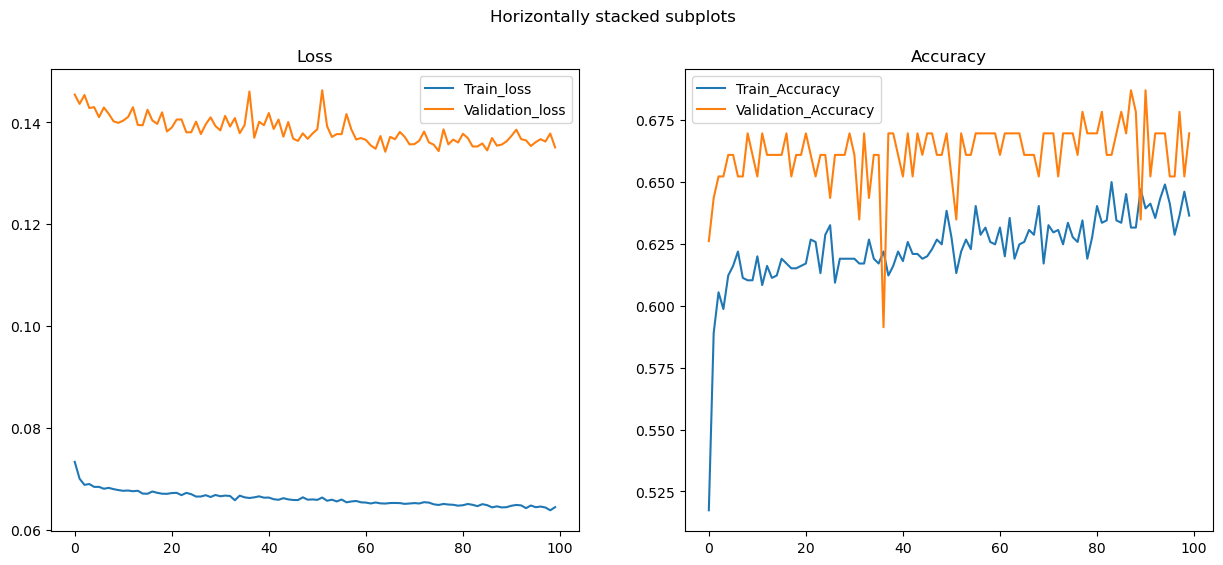

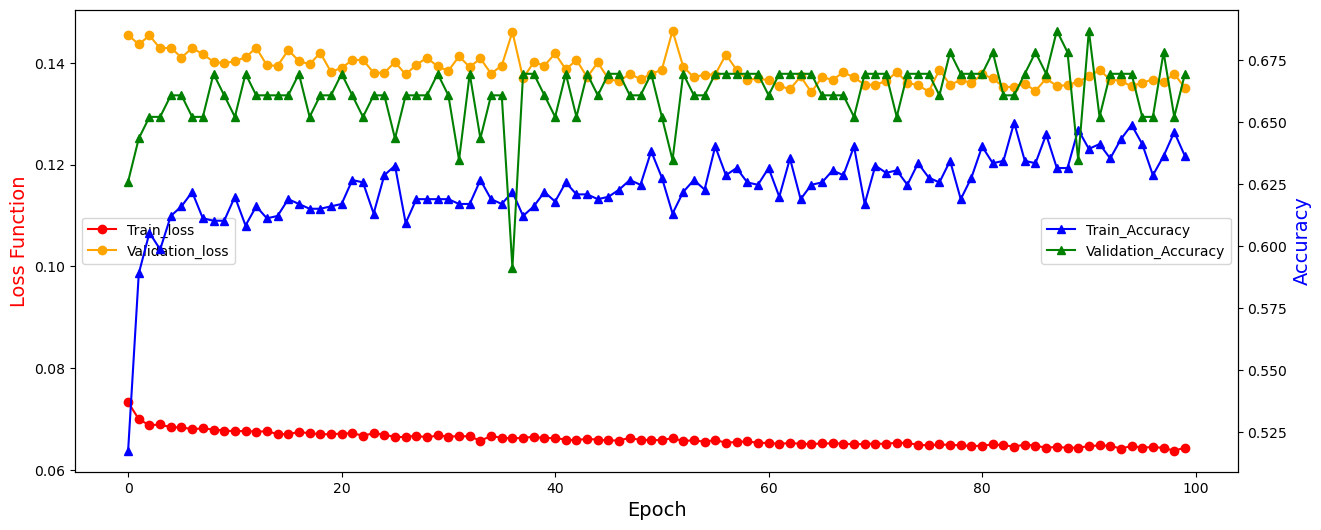

Current time: 36.041 minutes. Time expected till completion: 144.165 minutes

Epoch 101 of 500


100%|██████████| 15/15 [00:00<00:00, 16.98it/s]


train loss:  0.06442437446324922
Val loss:  0.13680476261221844
train accuracy:  0.6363636363636364
Val accuracy:  0.6608695652173913
Current time: 36.352 minutes. Time expected till completion: 143.609 minutes

Epoch 102 of 500


100%|██████████| 15/15 [00:00<00:00, 16.69it/s]


train loss:  0.06408767093772814
Val loss:  0.13671694164690765
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 36.663 minutes. Time expected till completion: 143.059 minutes

Epoch 103 of 500


100%|██████████| 15/15 [00:00<00:00, 16.80it/s]


train loss:  0.06451188284377757
Val loss:  0.13504276534785395
train accuracy:  0.6411992263056093
Val accuracy:  0.6608695652173913
Current time: 36.974 minutes. Time expected till completion: 142.510 minutes

Epoch 104 of 500


100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


train loss:  0.0643951687061118
Val loss:  0.13560899288757988
train accuracy:  0.6441005802707931
Val accuracy:  0.6695652173913044
Current time: 37.282 minutes. Time expected till completion: 141.958 minutes

Epoch 105 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.06415524485032839
Val loss:  0.1369301526442818
train accuracy:  0.6305609284332688
Val accuracy:  0.6782608695652174
Current time: 37.590 minutes. Time expected till completion: 141.408 minutes

Epoch 106 of 500


100%|██████████| 15/15 [00:00<00:00, 16.53it/s]


train loss:  0.06431330749098521
Val loss:  0.13673969870028288
train accuracy:  0.6479690522243714
Val accuracy:  0.6782608695652174
Current time: 37.901 minutes. Time expected till completion: 140.876 minutes

Epoch 107 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.0633191796059304
Val loss:  0.13516381875328395
train accuracy:  0.6508704061895552
Val accuracy:  0.6782608695652174
Current time: 38.212 minutes. Time expected till completion: 140.350 minutes

Epoch 108 of 500


100%|██████████| 15/15 [00:00<00:00, 16.56it/s]


train loss:  0.06423524575491708
Val loss:  0.13425493395846824
train accuracy:  0.6518375241779497
Val accuracy:  0.6608695652173913
Current time: 38.523 minutes. Time expected till completion: 139.825 minutes

Epoch 109 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.06387882692670914
Val loss:  0.13602902681931206
train accuracy:  0.6566731141199227
Val accuracy:  0.6782608695652174
Current time: 38.832 minutes. Time expected till completion: 139.296 minutes

Epoch 110 of 500


100%|██████████| 15/15 [00:00<00:00, 16.56it/s]


train loss:  0.0639888360606402
Val loss:  0.13849445581436157
train accuracy:  0.6441005802707931
Val accuracy:  0.6695652173913044
Current time: 39.142 minutes. Time expected till completion: 138.777 minutes

Epoch 111 of 500


100%|██████████| 15/15 [00:00<00:00, 16.77it/s]


train loss:  0.06443658747802158
Val loss:  0.13487804402475773
train accuracy:  0.6441005802707931
Val accuracy:  0.6695652173913044
Current time: 39.452 minutes. Time expected till completion: 138.261 minutes

Epoch 112 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.06426666985397413
Val loss:  0.1372242352236872
train accuracy:  0.6392649903288201
Val accuracy:  0.6608695652173913
Current time: 39.763 minutes. Time expected till completion: 137.750 minutes

Epoch 113 of 500


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


train loss:  0.06381211486037972
Val loss:  0.1362118705459263
train accuracy:  0.6363636363636364
Val accuracy:  0.6869565217391305
Current time: 40.071 minutes. Time expected till completion: 137.236 minutes

Epoch 114 of 500


100%|██████████| 15/15 [00:00<00:00, 16.45it/s]


train loss:  0.06354516588972892
Val loss:  0.13845255167587944
train accuracy:  0.6382978723404256
Val accuracy:  0.6695652173913044
Current time: 40.383 minutes. Time expected till completion: 136.734 minutes

Epoch 115 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.06384327362077148
Val loss:  0.1347518221191738
train accuracy:  0.6479690522243714
Val accuracy:  0.6869565217391305
Current time: 40.691 minutes. Time expected till completion: 136.226 minutes

Epoch 116 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.0638786098943227
Val loss:  0.13444220708764118
train accuracy:  0.6595744680851063
Val accuracy:  0.6782608695652174
Current time: 41.003 minutes. Time expected till completion: 135.732 minutes

Epoch 117 of 500


100%|██████████| 15/15 [00:00<00:00, 17.63it/s]


train loss:  0.0642588977887506
Val loss:  0.13682618141174316
train accuracy:  0.6499032882011605
Val accuracy:  0.6521739130434783
Current time: 41.311 minutes. Time expected till completion: 135.231 minutes

Epoch 118 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.063597609676291
Val loss:  0.13620559391768083
train accuracy:  0.660541586073501
Val accuracy:  0.6695652173913044
Current time: 41.620 minutes. Time expected till completion: 134.734 minutes

Epoch 119 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.06377551812729014
Val loss:  0.13763335010279779
train accuracy:  0.6421663442940039
Val accuracy:  0.6608695652173913
Current time: 41.929 minutes. Time expected till completion: 134.243 minutes

Epoch 120 of 500


100%|██████████| 15/15 [00:00<00:00, 16.99it/s]


train loss:  0.06353414514078623
Val loss:  0.14305516896040543
train accuracy:  0.648936170212766
Val accuracy:  0.6
Current time: 42.242 minutes. Time expected till completion: 133.766 minutes

Epoch 121 of 500


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


train loss:  0.06401942846161715
Val loss:  0.1366501948107844
train accuracy:  0.648936170212766
Val accuracy:  0.6782608695652174
Current time: 42.552 minutes. Time expected till completion: 133.284 minutes

Epoch 122 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.06362976522925283
Val loss:  0.13536768529726112
train accuracy:  0.6470019342359767
Val accuracy:  0.6782608695652174
Current time: 42.862 minutes. Time expected till completion: 132.802 minutes

Epoch 123 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.06392939691386786
Val loss:  0.1368622318558071
train accuracy:  0.6460348162475822
Val accuracy:  0.6608695652173913
Current time: 43.169 minutes. Time expected till completion: 132.315 minutes

Epoch 124 of 500


100%|██████████| 15/15 [00:00<00:00, 17.63it/s]


train loss:  0.06359318181209453
Val loss:  0.1357037585714589
train accuracy:  0.6431334622823984
Val accuracy:  0.6695652173913044
Current time: 43.479 minutes. Time expected till completion: 131.838 minutes

Epoch 125 of 500


100%|██████████| 15/15 [00:00<00:00, 16.88it/s]


train loss:  0.06371120431206444
Val loss:  0.1359402677287226
train accuracy:  0.6421663442940039
Val accuracy:  0.6695652173913044
Current time: 43.787 minutes. Time expected till completion: 131.362 minutes

Epoch 126 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.06371979037843774
Val loss:  0.13674438932667607
train accuracy:  0.6470019342359767
Val accuracy:  0.6521739130434783
Current time: 44.098 minutes. Time expected till completion: 130.895 minutes

Epoch 127 of 500


100%|██████████| 15/15 [00:00<00:00, 16.82it/s]


train loss:  0.0636690405973844
Val loss:  0.1370844726977141
train accuracy:  0.655705996131528
Val accuracy:  0.6434782608695652
Current time: 44.407 minutes. Time expected till completion: 130.423 minutes

Epoch 128 of 500


100%|██████████| 15/15 [00:00<00:00, 17.69it/s]


train loss:  0.06368221893070745
Val loss:  0.13562704117401786
train accuracy:  0.6344294003868471
Val accuracy:  0.6782608695652174
Current time: 44.715 minutes. Time expected till completion: 129.953 minutes

Epoch 129 of 500


100%|██████████| 15/15 [00:00<00:00, 16.62it/s]


train loss:  0.06359801486105707
Val loss:  0.13576461232226827
train accuracy:  0.6566731141199227
Val accuracy:  0.6782608695652174
Current time: 45.025 minutes. Time expected till completion: 129.490 minutes

Epoch 130 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.06387945600358384
Val loss:  0.1351711656736291
train accuracy:  0.6411992263056093
Val accuracy:  0.6521739130434783
Current time: 45.334 minutes. Time expected till completion: 129.029 minutes

Epoch 131 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.06349745704080888
Val loss:  0.13768257472826087
train accuracy:  0.655705996131528
Val accuracy:  0.6521739130434783
Current time: 45.646 minutes. Time expected till completion: 128.575 minutes

Epoch 132 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.06298764796506044
Val loss:  0.13598839925683062
train accuracy:  0.648936170212766
Val accuracy:  0.6521739130434783
Current time: 45.956 minutes. Time expected till completion: 128.120 minutes

Epoch 133 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.06347440405094877
Val loss:  0.13598237348639447
train accuracy:  0.6508704061895552
Val accuracy:  0.6695652173913044
Current time: 46.268 minutes. Time expected till completion: 127.671 minutes

Epoch 134 of 500


100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


train loss:  0.06321824876667222
Val loss:  0.13547299633855406
train accuracy:  0.6499032882011605
Val accuracy:  0.6608695652173913
Current time: 46.577 minutes. Time expected till completion: 127.219 minutes

Epoch 135 of 500


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


train loss:  0.0630470668785346
Val loss:  0.13642090610835864
train accuracy:  0.6547388781431335
Val accuracy:  0.6782608695652174
Current time: 46.886 minutes. Time expected till completion: 126.765 minutes

Epoch 136 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.06349864434919228
Val loss:  0.13559235645377118
train accuracy:  0.6537717601547389
Val accuracy:  0.6695652173913044
Current time: 47.202 minutes. Time expected till completion: 126.334 minutes

Epoch 137 of 500


100%|██████████| 15/15 [00:00<00:00, 17.84it/s]


train loss:  0.06346229606486381
Val loss:  0.13710167356159375
train accuracy:  0.6518375241779497
Val accuracy:  0.6608695652173913
Current time: 47.511 minutes. Time expected till completion: 125.887 minutes

Epoch 138 of 500


100%|██████████| 15/15 [00:00<00:00, 16.77it/s]


train loss:  0.06360411084828109
Val loss:  0.1349511136179385
train accuracy:  0.6470019342359767
Val accuracy:  0.6695652173913044
Current time: 47.823 minutes. Time expected till completion: 125.448 minutes

Epoch 139 of 500


100%|██████████| 15/15 [00:00<00:00, 16.66it/s]


train loss:  0.06335515556298557
Val loss:  0.13631521929865298
train accuracy:  0.6518375241779497
Val accuracy:  0.6608695652173913
Current time: 48.135 minutes. Time expected till completion: 125.014 minutes

Epoch 140 of 500


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


train loss:  0.06287828894832839
Val loss:  0.13536498753920845
train accuracy:  0.6537717601547389
Val accuracy:  0.6695652173913044
Current time: 48.444 minutes. Time expected till completion: 124.570 minutes

Epoch 141 of 500


100%|██████████| 15/15 [00:00<00:00, 16.56it/s]


train loss:  0.06313060520926574
Val loss:  0.13577020945756332
train accuracy:  0.6479690522243714
Val accuracy:  0.6869565217391305
Current time: 48.754 minutes. Time expected till completion: 124.134 minutes

Epoch 142 of 500


100%|██████████| 15/15 [00:00<00:00, 16.55it/s]


train loss:  0.06313878488033375
Val loss:  0.13799194149349048
train accuracy:  0.6615087040618955
Val accuracy:  0.6521739130434783
Current time: 49.065 minutes. Time expected till completion: 123.698 minutes

Epoch 143 of 500


100%|██████████| 15/15 [00:00<00:00, 16.60it/s]


train loss:  0.06281076288084919
Val loss:  0.13605494862017425
train accuracy:  0.6499032882011605
Val accuracy:  0.6608695652173913
Current time: 49.376 minutes. Time expected till completion: 123.267 minutes

Epoch 144 of 500


100%|██████████| 15/15 [00:00<00:00, 15.65it/s]


train loss:  0.06336051646468718
Val loss:  0.13474506865377012
train accuracy:  0.655705996131528
Val accuracy:  0.6869565217391305
Current time: 49.686 minutes. Time expected till completion: 122.836 minutes

Epoch 145 of 500


100%|██████████| 15/15 [00:00<00:00, 17.72it/s]


train loss:  0.06300761436816571
Val loss:  0.13781029193297675
train accuracy:  0.6586073500967118
Val accuracy:  0.6434782608695652
Current time: 49.997 minutes. Time expected till completion: 122.407 minutes

Epoch 146 of 500


100%|██████████| 15/15 [00:00<00:00, 16.88it/s]


train loss:  0.06315163971146485
Val loss:  0.13530778366586435
train accuracy:  0.6624758220502901
Val accuracy:  0.6695652173913044
Current time: 50.307 minutes. Time expected till completion: 121.978 minutes

Epoch 147 of 500


100%|██████████| 15/15 [00:00<00:00, 16.53it/s]


train loss:  0.06302866697080822
Val loss:  0.13456808276798415
train accuracy:  0.6576402321083172
Val accuracy:  0.6608695652173913
Current time: 50.617 minutes. Time expected till completion: 121.551 minutes

Epoch 148 of 500


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


train loss:  0.06268362161961008
Val loss:  0.13687174216560696
train accuracy:  0.655705996131528
Val accuracy:  0.6782608695652174
Current time: 50.926 minutes. Time expected till completion: 121.121 minutes

Epoch 149 of 500


100%|██████████| 15/15 [00:00<00:00, 17.69it/s]


train loss:  0.06360455655728825
Val loss:  0.1361643495767013
train accuracy:  0.6460348162475822
Val accuracy:  0.6956521739130435
Current time: 51.234 minutes. Time expected till completion: 120.691 minutes

Epoch 150 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.0631683319518829
Val loss:  0.13698383621547533
train accuracy:  0.6576402321083172
Val accuracy:  0.6695652173913044
Current time: 51.544 minutes. Time expected till completion: 120.269 minutes

Epoch 151 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.06312295419796292
Val loss:  0.13617198000783506
train accuracy:  0.6644100580270793
Val accuracy:  0.6782608695652174
Current time: 51.854 minutes. Time expected till completion: 119.848 minutes

Epoch 152 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.06275532485438039
Val loss:  0.13778766290001246
train accuracy:  0.6576402321083172
Val accuracy:  0.6782608695652174
Current time: 52.163 minutes. Time expected till completion: 119.426 minutes

Epoch 153 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.06316101430001987
Val loss:  0.13658062375110128
train accuracy:  0.6479690522243714
Val accuracy:  0.6434782608695652
Current time: 52.472 minutes. Time expected till completion: 119.006 minutes

Epoch 154 of 500


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


train loss:  0.0627991910483436
Val loss:  0.13736575841903687
train accuracy:  0.6479690522243714
Val accuracy:  0.6521739130434783
Current time: 52.781 minutes. Time expected till completion: 118.587 minutes

Epoch 155 of 500


100%|██████████| 15/15 [00:00<00:00, 16.64it/s]


train loss:  0.06337455278208454
Val loss:  0.13584192576615706
train accuracy:  0.6566731141199227
Val accuracy:  0.6608695652173913
Current time: 53.092 minutes. Time expected till completion: 118.173 minutes

Epoch 156 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.06265815320051846
Val loss:  0.1377962589263916
train accuracy:  0.6624758220502901
Val accuracy:  0.6521739130434783
Current time: 53.400 minutes. Time expected till completion: 117.755 minutes

Epoch 157 of 500


100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


train loss:  0.06260559671852067
Val loss:  0.13725349073824675
train accuracy:  0.6644100580270793
Val accuracy:  0.6695652173913044
Current time: 53.712 minutes. Time expected till completion: 117.345 minutes

Epoch 158 of 500


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


train loss:  0.0627576588892614
Val loss:  0.1362500926722651
train accuracy:  0.6644100580270793
Val accuracy:  0.6782608695652174
Current time: 54.021 minutes. Time expected till completion: 116.931 minutes

Epoch 159 of 500


100%|██████████| 15/15 [00:00<00:00, 16.67it/s]


train loss:  0.06269411503461621
Val loss:  0.1354048956995425
train accuracy:  0.6518375241779497
Val accuracy:  0.6782608695652174
Current time: 54.331 minutes. Time expected till completion: 116.522 minutes

Epoch 160 of 500


100%|██████████| 15/15 [00:00<00:00, 16.79it/s]


train loss:  0.06285146115135178
Val loss:  0.13837961684102598
train accuracy:  0.6653771760154739
Val accuracy:  0.6695652173913044
Current time: 54.640 minutes. Time expected till completion: 116.110 minutes

Epoch 161 of 500


100%|██████████| 15/15 [00:00<00:00, 16.96it/s]


train loss:  0.06342678432077227
Val loss:  0.13638498161150062
train accuracy:  0.6518375241779497
Val accuracy:  0.6782608695652174
Current time: 54.950 minutes. Time expected till completion: 115.702 minutes

Epoch 162 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.0627759462168415
Val loss:  0.13650237995645273
train accuracy:  0.6576402321083172
Val accuracy:  0.6695652173913044
Current time: 55.260 minutes. Time expected till completion: 115.296 minutes

Epoch 163 of 500


100%|██████████| 15/15 [00:00<00:00, 16.80it/s]


train loss:  0.06282630384083643
Val loss:  0.1358277880627176
train accuracy:  0.6731141199226306
Val accuracy:  0.6782608695652174
Current time: 55.574 minutes. Time expected till completion: 114.898 minutes

Epoch 164 of 500


100%|██████████| 15/15 [00:00<00:00, 16.53it/s]


train loss:  0.06251997251344603
Val loss:  0.135873660315638
train accuracy:  0.6653771760154739
Val accuracy:  0.6608695652173913
Current time: 55.881 minutes. Time expected till completion: 114.488 minutes

Epoch 165 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.06303403640392902
Val loss:  0.1371513097182564
train accuracy:  0.6653771760154739
Val accuracy:  0.6956521739130435
Current time: 56.190 minutes. Time expected till completion: 114.083 minutes

Epoch 166 of 500


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


train loss:  0.06272782739864327
Val loss:  0.13667453009149302
train accuracy:  0.6653771760154739
Val accuracy:  0.6869565217391305
Current time: 56.499 minutes. Time expected till completion: 113.678 minutes

Epoch 167 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.06316892338675272
Val loss:  0.13559563263602878
train accuracy:  0.6586073500967118
Val accuracy:  0.6608695652173913
Current time: 56.809 minutes. Time expected till completion: 113.277 minutes

Epoch 168 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.06226697742823706
Val loss:  0.1363884360893913
train accuracy:  0.6653771760154739
Val accuracy:  0.6782608695652174
Current time: 57.118 minutes. Time expected till completion: 112.875 minutes

Epoch 169 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.0625678398853575
Val loss:  0.13637216091156007
train accuracy:  0.6537717601547389
Val accuracy:  0.6608695652173913
Current time: 57.430 minutes. Time expected till completion: 112.480 minutes

Epoch 170 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.061817235423241176
Val loss:  0.13589077669641245
train accuracy:  0.6682785299806576
Val accuracy:  0.6782608695652174
Current time: 57.740 minutes. Time expected till completion: 112.083 minutes

Epoch 171 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.06275175664595524
Val loss:  0.13779312372207642
train accuracy:  0.6624758220502901
Val accuracy:  0.6608695652173913
Current time: 58.051 minutes. Time expected till completion: 111.688 minutes

Epoch 172 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.06273220857061317
Val loss:  0.13625104530997897
train accuracy:  0.6566731141199227
Val accuracy:  0.6782608695652174
Current time: 58.360 minutes. Time expected till completion: 111.291 minutes

Epoch 173 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.062432765787759185
Val loss:  0.13875626170116923
train accuracy:  0.6586073500967118
Val accuracy:  0.6695652173913044
Current time: 58.669 minutes. Time expected till completion: 110.894 minutes

Epoch 174 of 500


100%|██████████| 15/15 [00:00<00:00, 16.55it/s]


train loss:  0.06226024043168044
Val loss:  0.13709724675054136
train accuracy:  0.660541586073501
Val accuracy:  0.6608695652173913
Current time: 58.979 minutes. Time expected till completion: 110.502 minutes

Epoch 175 of 500


100%|██████████| 15/15 [00:00<00:00, 16.86it/s]


train loss:  0.06295178032244197
Val loss:  0.13804288065951803
train accuracy:  0.6634429400386848
Val accuracy:  0.6782608695652174
Current time: 59.288 minutes. Time expected till completion: 110.107 minutes

Epoch 176 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.06265186710099417
Val loss:  0.13596827413724816
train accuracy:  0.6624758220502901
Val accuracy:  0.6695652173913044
Current time: 59.598 minutes. Time expected till completion: 109.715 minutes

Epoch 177 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.06244511253829159
Val loss:  0.13648180184157
train accuracy:  0.6769825918762089
Val accuracy:  0.6695652173913044
Current time: 59.904 minutes. Time expected till completion: 109.317 minutes

Epoch 178 of 500


100%|██████████| 15/15 [00:00<00:00, 16.66it/s]


train loss:  0.06222522276051962
Val loss:  0.13763801222262176
train accuracy:  0.6547388781431335
Val accuracy:  0.6695652173913044
Current time: 60.215 minutes. Time expected till completion: 108.928 minutes

Epoch 179 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.06261178430321138
Val loss:  0.1369527878968612
train accuracy:  0.6644100580270793
Val accuracy:  0.6521739130434783
Current time: 60.524 minutes. Time expected till completion: 108.538 minutes

Epoch 180 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.06255602035347221
Val loss:  0.13417224002921063
train accuracy:  0.6740812379110251
Val accuracy:  0.6608695652173913
Current time: 60.834 minutes. Time expected till completion: 108.149 minutes

Epoch 181 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.06277881744290689
Val loss:  0.1353748005369435
train accuracy:  0.6566731141199227
Val accuracy:  0.6782608695652174
Current time: 61.144 minutes. Time expected till completion: 107.763 minutes

Epoch 182 of 500


100%|██████████| 15/15 [00:00<00:00, 16.37it/s]


train loss:  0.06225897345828826
Val loss:  0.13704535702000495
train accuracy:  0.6711798839458414
Val accuracy:  0.6521739130434783
Current time: 61.454 minutes. Time expected till completion: 107.375 minutes

Epoch 183 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.06180476900226143
Val loss:  0.13787576633950938
train accuracy:  0.6624758220502901
Val accuracy:  0.6869565217391305
Current time: 61.763 minutes. Time expected till completion: 106.988 minutes

Epoch 184 of 500


100%|██████████| 15/15 [00:00<00:00, 16.69it/s]


train loss:  0.062176078385033966
Val loss:  0.13727342564126718
train accuracy:  0.6653771760154739
Val accuracy:  0.6695652173913044
Current time: 62.072 minutes. Time expected till completion: 106.602 minutes

Epoch 185 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.06215425651354762
Val loss:  0.138539893730827
train accuracy:  0.6615087040618955
Val accuracy:  0.7043478260869566
Current time: 62.380 minutes. Time expected till completion: 106.215 minutes

Epoch 186 of 500


100%|██████████| 15/15 [00:00<00:00, 16.60it/s]


train loss:  0.061980650491825155
Val loss:  0.14048726610515427
train accuracy:  0.6789168278529981
Val accuracy:  0.6434782608695652
Current time: 62.690 minutes. Time expected till completion: 105.831 minutes

Epoch 187 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.06192570503952425
Val loss:  0.1360832032950028
train accuracy:  0.6711798839458414
Val accuracy:  0.6869565217391305
Current time: 62.999 minutes. Time expected till completion: 105.448 minutes

Epoch 188 of 500


100%|██████████| 15/15 [00:00<00:00, 16.19it/s]


train loss:  0.06215504543924239
Val loss:  0.1395284398742344
train accuracy:  0.6808510638297872
Val accuracy:  0.6608695652173913
Current time: 63.311 minutes. Time expected till completion: 105.070 minutes

Epoch 189 of 500


100%|██████████| 15/15 [00:00<00:00, 16.60it/s]


train loss:  0.062309056462817314
Val loss:  0.13618263369021208
train accuracy:  0.6586073500967118
Val accuracy:  0.6782608695652174
Current time: 63.624 minutes. Time expected till completion: 104.693 minutes

Epoch 190 of 500


100%|██████████| 15/15 [00:00<00:00, 17.69it/s]


train loss:  0.061751683053472284
Val loss:  0.13737732379332832
train accuracy:  0.6595744680851063
Val accuracy:  0.6695652173913044
Current time: 63.931 minutes. Time expected till completion: 104.309 minutes

Epoch 191 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.06165476641987002
Val loss:  0.1356131102727807
train accuracy:  0.6595744680851063
Val accuracy:  0.6521739130434783
Current time: 64.240 minutes. Time expected till completion: 103.928 minutes

Epoch 192 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.06260946393013
Val loss:  0.13603844694469286
train accuracy:  0.6586073500967118
Val accuracy:  0.6695652173913044
Current time: 64.549 minutes. Time expected till completion: 103.547 minutes

Epoch 193 of 500


100%|██████████| 15/15 [00:00<00:00, 16.60it/s]


train loss:  0.06174383979701442
Val loss:  0.1365273776261703
train accuracy:  0.6808510638297872
Val accuracy:  0.6521739130434783
Current time: 64.860 minutes. Time expected till completion: 103.171 minutes

Epoch 194 of 500


100%|██████████| 15/15 [00:00<00:00, 16.66it/s]


train loss:  0.06154651095373718
Val loss:  0.13955539775931317
train accuracy:  0.6731141199226306
Val accuracy:  0.6869565217391305
Current time: 65.173 minutes. Time expected till completion: 102.799 minutes

Epoch 195 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.06195085157047619
Val loss:  0.1374974727630615
train accuracy:  0.6798839458413927
Val accuracy:  0.6869565217391305
Current time: 65.483 minutes. Time expected till completion: 102.422 minutes

Epoch 196 of 500


100%|██████████| 15/15 [00:00<00:00, 16.62it/s]


train loss:  0.061589585916216646
Val loss:  0.13685955638470856
train accuracy:  0.6740812379110251
Val accuracy:  0.6695652173913044
Current time: 65.792 minutes. Time expected till completion: 102.044 minutes

Epoch 197 of 500


100%|██████████| 15/15 [00:00<00:00, 16.66it/s]


train loss:  0.061910472939969034
Val loss:  0.14013575470965842
train accuracy:  0.660541586073501
Val accuracy:  0.6695652173913044
Current time: 66.101 minutes. Time expected till completion: 101.668 minutes

Epoch 198 of 500


100%|██████████| 15/15 [00:00<00:00, 16.56it/s]


train loss:  0.06162031522341346
Val loss:  0.13537525301394254
train accuracy:  0.6760154738878144
Val accuracy:  0.6869565217391305
Current time: 66.411 minutes. Time expected till completion: 101.293 minutes

Epoch 199 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.06210165264758658
Val loss:  0.1364971207535785
train accuracy:  0.6615087040618955
Val accuracy:  0.6695652173913044
Current time: 66.720 minutes. Time expected till completion: 100.918 minutes

Epoch 200 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.06199703283420614
Val loss:  0.13549358067305192
train accuracy:  0.6740812379110251
Val accuracy:  0.6782608695652174
Saving model checkpoint


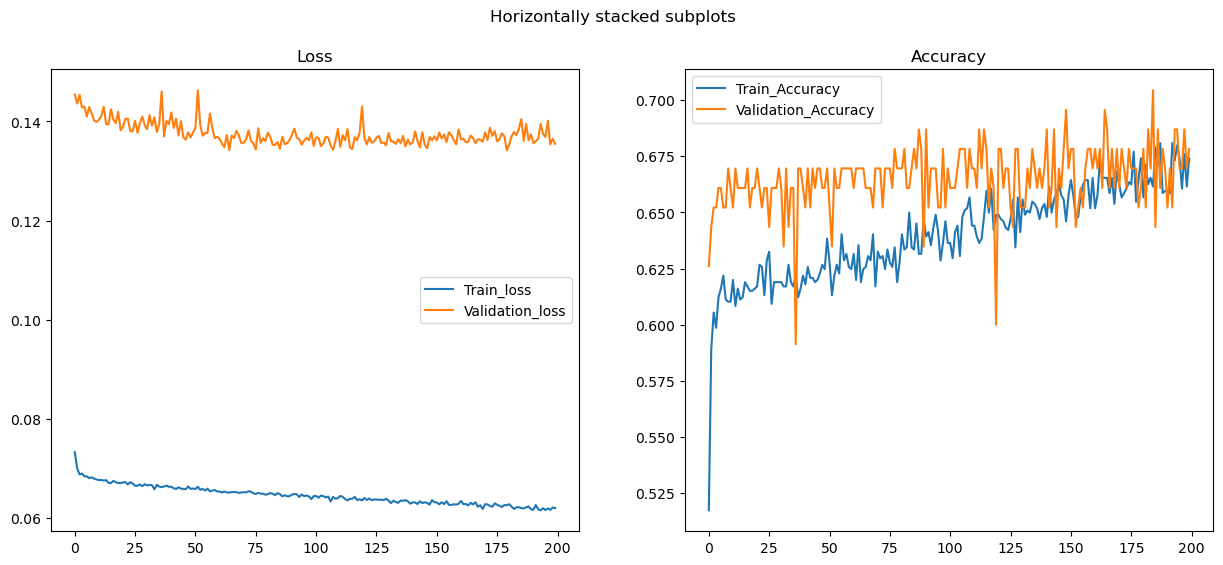

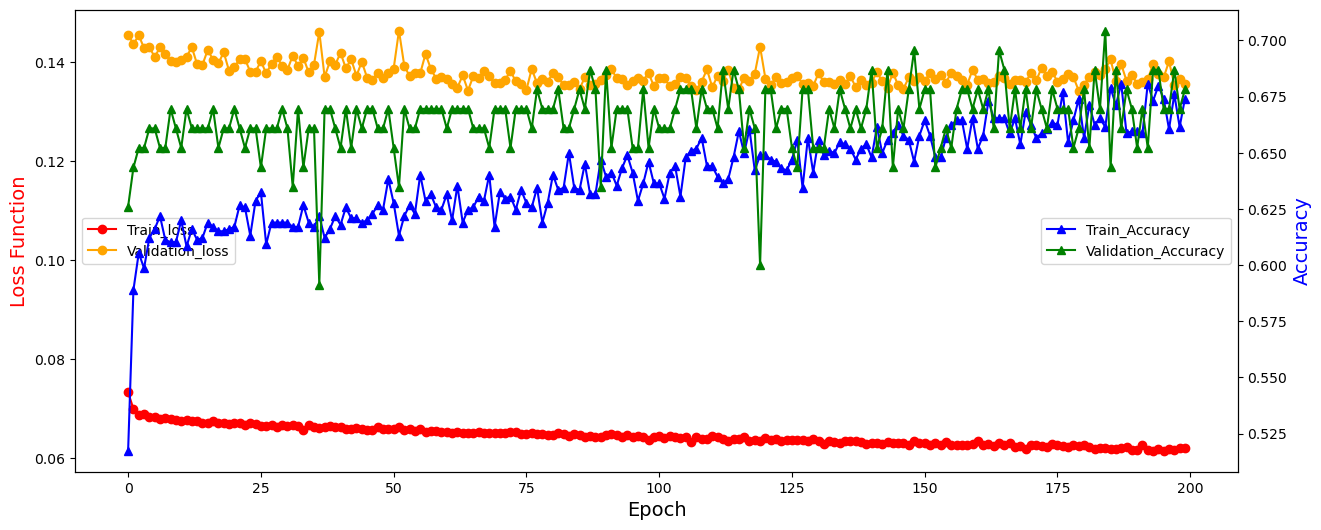

Current time: 67.045 minutes. Time expected till completion: 100.567 minutes

Epoch 201 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.061885923493069886
Val loss:  0.13541375657786495
train accuracy:  0.6721470019342359
Val accuracy:  0.7043478260869566
Current time: 67.357 minutes. Time expected till completion: 100.197 minutes

Epoch 202 of 500


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


train loss:  0.06165864285463521
Val loss:  0.13797570052354233
train accuracy:  0.6750483558994197
Val accuracy:  0.6782608695652174
Current time: 67.665 minutes. Time expected till completion: 99.822 minutes

Epoch 203 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.061977227548104884
Val loss:  0.13601251114969667
train accuracy:  0.6653771760154739
Val accuracy:  0.6695652173913044
Current time: 67.976 minutes. Time expected till completion: 99.453 minutes

Epoch 204 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.06200754815420745
Val loss:  0.13740730130154152
train accuracy:  0.6750483558994197
Val accuracy:  0.6695652173913044
Current time: 68.285 minutes. Time expected till completion: 99.080 minutes

Epoch 205 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.0620115822472932
Val loss:  0.13618684955265212
train accuracy:  0.6798839458413927
Val accuracy:  0.6608695652173913
Current time: 68.596 minutes. Time expected till completion: 98.711 minutes

Epoch 206 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06199561114237433
Val loss:  0.13539393932923027
train accuracy:  0.6769825918762089
Val accuracy:  0.6608695652173913
Current time: 68.906 minutes. Time expected till completion: 98.342 minutes

Epoch 207 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.06158731926801818
Val loss:  0.13661879612051922
train accuracy:  0.6711798839458414
Val accuracy:  0.6608695652173913
Current time: 69.217 minutes. Time expected till completion: 97.973 minutes

Epoch 208 of 500


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


train loss:  0.0615560306340629
Val loss:  0.13758126341778298
train accuracy:  0.6750483558994197
Val accuracy:  0.6695652173913044
Current time: 69.526 minutes. Time expected till completion: 97.603 minutes

Epoch 209 of 500


100%|██████████| 15/15 [00:00<00:00, 16.55it/s]


train loss:  0.061562906669694176
Val loss:  0.13823366268821385
train accuracy:  0.6827852998065764
Val accuracy:  0.6782608695652174
Current time: 69.836 minutes. Time expected till completion: 97.235 minutes

Epoch 210 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.06197785391567754
Val loss:  0.13627611346866775
train accuracy:  0.6769825918762089
Val accuracy:  0.6782608695652174
Current time: 70.146 minutes. Time expected till completion: 96.868 minutes

Epoch 211 of 500


100%|██████████| 15/15 [00:00<00:00, 16.66it/s]


train loss:  0.0618176242369056
Val loss:  0.1395733480868132
train accuracy:  0.6721470019342359
Val accuracy:  0.6782608695652174
Current time: 70.456 minutes. Time expected till completion: 96.501 minutes

Epoch 212 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.061629618908957774
Val loss:  0.13783730631289276
train accuracy:  0.6818181818181818
Val accuracy:  0.6695652173913044
Current time: 70.766 minutes. Time expected till completion: 96.134 minutes

Epoch 213 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.061805652580593264
Val loss:  0.13603326600530874
train accuracy:  0.6663442940038685
Val accuracy:  0.6869565217391305
Current time: 71.077 minutes. Time expected till completion: 95.771 minutes

Epoch 214 of 500


100%|██████████| 15/15 [00:00<00:00, 16.98it/s]


train loss:  0.061352679934676885
Val loss:  0.13682275025740914
train accuracy:  0.6740812379110251
Val accuracy:  0.7043478260869566
Current time: 71.389 minutes. Time expected till completion: 95.408 minutes

Epoch 215 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.06139950088191078
Val loss:  0.1367367210595504
train accuracy:  0.6847195357833655
Val accuracy:  0.6956521739130435
Current time: 71.699 minutes. Time expected till completion: 95.043 minutes

Epoch 216 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.06100931515776673
Val loss:  0.13668390927107438
train accuracy:  0.7011605415860735
Val accuracy:  0.6782608695652174
Current time: 72.010 minutes. Time expected till completion: 94.680 minutes

Epoch 217 of 500


100%|██████████| 15/15 [00:00<00:00, 16.98it/s]


train loss:  0.061558552994257706
Val loss:  0.13579535691634467
train accuracy:  0.6798839458413927
Val accuracy:  0.6782608695652174
Current time: 72.320 minutes. Time expected till completion: 94.316 minutes

Epoch 218 of 500


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


train loss:  0.061368719348593885
Val loss:  0.13710583707560664
train accuracy:  0.6856866537717602
Val accuracy:  0.6521739130434783
Current time: 72.631 minutes. Time expected till completion: 93.954 minutes

Epoch 219 of 500


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


train loss:  0.06164091952303623
Val loss:  0.13563496911007425
train accuracy:  0.6924564796905223
Val accuracy:  0.6869565217391305
Current time: 72.941 minutes. Time expected till completion: 93.592 minutes

Epoch 220 of 500


100%|██████████| 15/15 [00:00<00:00, 16.66it/s]


train loss:  0.061728188043867364
Val loss:  0.13980579894521963
train accuracy:  0.6982591876208898
Val accuracy:  0.6869565217391305
Current time: 73.252 minutes. Time expected till completion: 93.230 minutes

Epoch 221 of 500


100%|██████████| 15/15 [00:00<00:00, 16.69it/s]


train loss:  0.06170025519752871
Val loss:  0.1344127592833146
train accuracy:  0.6866537717601547
Val accuracy:  0.6782608695652174
Current time: 73.560 minutes. Time expected till completion: 92.865 minutes

Epoch 222 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.06118188098044183
Val loss:  0.13557899516561758
train accuracy:  0.688588007736944
Val accuracy:  0.6695652173913044
Current time: 73.869 minutes. Time expected till completion: 92.502 minutes

Epoch 223 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.06158992809529922
Val loss:  0.1368885688159777
train accuracy:  0.6827852998065764
Val accuracy:  0.6869565217391305
Current time: 74.180 minutes. Time expected till completion: 92.143 minutes

Epoch 224 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.061432367079032
Val loss:  0.14183465138725612
train accuracy:  0.6924564796905223
Val accuracy:  0.6521739130434783
Current time: 74.491 minutes. Time expected till completion: 91.783 minutes

Epoch 225 of 500


100%|██████████| 15/15 [00:00<00:00, 16.56it/s]


train loss:  0.06137381612216942
Val loss:  0.13822119857953943
train accuracy:  0.6789168278529981
Val accuracy:  0.6695652173913044
Current time: 74.800 minutes. Time expected till completion: 91.422 minutes

Epoch 226 of 500


100%|██████████| 15/15 [00:00<00:00, 16.88it/s]


train loss:  0.061604576369088206
Val loss:  0.13707903001619423
train accuracy:  0.6779497098646035
Val accuracy:  0.6869565217391305
Current time: 75.108 minutes. Time expected till completion: 91.061 minutes

Epoch 227 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.06108977773895116
Val loss:  0.1356007404949354
train accuracy:  0.6634429400386848
Val accuracy:  0.6956521739130435
Current time: 75.420 minutes. Time expected till completion: 90.703 minutes

Epoch 228 of 500


100%|██████████| 15/15 [00:00<00:00, 16.56it/s]


train loss:  0.06131857310780243
Val loss:  0.13801828726478246
train accuracy:  0.6866537717601547
Val accuracy:  0.6782608695652174
Current time: 75.730 minutes. Time expected till completion: 90.345 minutes

Epoch 229 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.061358741508000594
Val loss:  0.13525432089100714
train accuracy:  0.683752417794971
Val accuracy:  0.6869565217391305
Current time: 76.037 minutes. Time expected till completion: 89.983 minutes

Epoch 230 of 500


100%|██████████| 15/15 [00:00<00:00, 16.80it/s]


train loss:  0.061152059231782095
Val loss:  0.13850441134494285
train accuracy:  0.6789168278529981
Val accuracy:  0.6695652173913044
Current time: 76.348 minutes. Time expected till completion: 89.626 minutes

Epoch 231 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.06161483666882985
Val loss:  0.1367345296818277
train accuracy:  0.6808510638297872
Val accuracy:  0.6869565217391305
Current time: 76.659 minutes. Time expected till completion: 89.270 minutes

Epoch 232 of 500


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


train loss:  0.06130941497518661
Val loss:  0.13729435153629468
train accuracy:  0.6876208897485493
Val accuracy:  0.6608695652173913
Current time: 76.969 minutes. Time expected till completion: 88.912 minutes

Epoch 233 of 500


100%|██████████| 15/15 [00:00<00:00, 17.69it/s]


train loss:  0.061327044230595776
Val loss:  0.1367942908535833
train accuracy:  0.6914893617021277
Val accuracy:  0.6869565217391305
Current time: 77.281 minutes. Time expected till completion: 88.558 minutes

Epoch 234 of 500


100%|██████████| 15/15 [00:00<00:00, 16.49it/s]


train loss:  0.06100724035121025
Val loss:  0.13961552640666133
train accuracy:  0.6914893617021277
Val accuracy:  0.6956521739130435
Current time: 77.590 minutes. Time expected till completion: 88.201 minutes

Epoch 235 of 500


100%|██████████| 15/15 [00:00<00:00, 17.67it/s]


train loss:  0.061060078658264426
Val loss:  0.13618237402128136
train accuracy:  0.7021276595744681
Val accuracy:  0.6782608695652174
Current time: 77.898 minutes. Time expected till completion: 87.843 minutes

Epoch 236 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.06107903443406583
Val loss:  0.13613008208896804
train accuracy:  0.6847195357833655
Val accuracy:  0.6869565217391305
Current time: 78.214 minutes. Time expected till completion: 87.493 minutes

Epoch 237 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.06081725746335559
Val loss:  0.13728677967320319
train accuracy:  0.6992263056092843
Val accuracy:  0.6695652173913044
Current time: 78.525 minutes. Time expected till completion: 87.140 minutes

Epoch 238 of 500


100%|██████████| 15/15 [00:00<00:00, 16.66it/s]


train loss:  0.061236575159390155
Val loss:  0.13600257894267206
train accuracy:  0.6847195357833655
Val accuracy:  0.6869565217391305
Current time: 78.834 minutes. Time expected till completion: 86.783 minutes

Epoch 239 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.0608432848056926
Val loss:  0.13508124973462976
train accuracy:  0.7011605415860735
Val accuracy:  0.6869565217391305
Current time: 79.144 minutes. Time expected till completion: 86.429 minutes

Epoch 240 of 500


100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


train loss:  0.06086983400571738
Val loss:  0.1358824838762698
train accuracy:  0.6789168278529981
Val accuracy:  0.6956521739130435
Current time: 79.454 minutes. Time expected till completion: 86.075 minutes

Epoch 241 of 500


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


train loss:  0.06126024615833792
Val loss:  0.13584503661031308
train accuracy:  0.6856866537717602
Val accuracy:  0.6782608695652174
Current time: 79.762 minutes. Time expected till completion: 85.720 minutes

Epoch 242 of 500


100%|██████████| 15/15 [00:00<00:00, 16.24it/s]


train loss:  0.060140729469303
Val loss:  0.13705839488817298
train accuracy:  0.706963249516441
Val accuracy:  0.6869565217391305
Current time: 80.071 minutes. Time expected till completion: 85.365 minutes

Epoch 243 of 500


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


train loss:  0.06139948497196692
Val loss:  0.1439755424209263
train accuracy:  0.6895551257253385
Val accuracy:  0.6434782608695652
Current time: 80.380 minutes. Time expected till completion: 85.011 minutes

Epoch 244 of 500


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


train loss:  0.06093389349242013
Val loss:  0.13826880765997845
train accuracy:  0.6992263056092843
Val accuracy:  0.6782608695652174
Current time: 80.689 minutes. Time expected till completion: 84.657 minutes

Epoch 245 of 500


100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


train loss:  0.06137547081397626
Val loss:  0.13898452157559602
train accuracy:  0.7011605415860735
Val accuracy:  0.6869565217391305
Current time: 81.000 minutes. Time expected till completion: 84.306 minutes

Epoch 246 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.060664770508642586
Val loss:  0.1359085228132165
train accuracy:  0.6876208897485493
Val accuracy:  0.6782608695652174
Current time: 81.308 minutes. Time expected till completion: 83.952 minutes

Epoch 247 of 500


100%|██████████| 15/15 [00:00<00:00, 17.72it/s]


train loss:  0.06068130070974103
Val loss:  0.13535064044206038
train accuracy:  0.6992263056092843
Val accuracy:  0.6782608695652174
Current time: 81.616 minutes. Time expected till completion: 83.599 minutes

Epoch 248 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.06086198510007655
Val loss:  0.1372992779897607
train accuracy:  0.6934235976789168
Val accuracy:  0.6869565217391305
Current time: 81.926 minutes. Time expected till completion: 83.247 minutes

Epoch 249 of 500


100%|██████████| 15/15 [00:00<00:00, 16.15it/s]


train loss:  0.06066642468164691
Val loss:  0.13580448264661044
train accuracy:  0.7050290135396519
Val accuracy:  0.6782608695652174
Current time: 82.236 minutes. Time expected till completion: 82.896 minutes

Epoch 250 of 500


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


train loss:  0.06070608136962876
Val loss:  0.13696406976036404
train accuracy:  0.7079303675048356
Val accuracy:  0.6782608695652174
Current time: 82.546 minutes. Time expected till completion: 82.546 minutes

Epoch 251 of 500


100%|██████████| 15/15 [00:00<00:00, 16.92it/s]


train loss:  0.06022867185695951
Val loss:  0.14091969521149345
train accuracy:  0.706963249516441
Val accuracy:  0.6260869565217392
Current time: 82.856 minutes. Time expected till completion: 82.196 minutes

Epoch 252 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.06068682509188034
Val loss:  0.13656053491260695
train accuracy:  0.706963249516441
Val accuracy:  0.6869565217391305
Current time: 83.164 minutes. Time expected till completion: 81.843 minutes

Epoch 253 of 500


100%|██████████| 15/15 [00:00<00:00, 17.76it/s]


train loss:  0.060963960404091695
Val loss:  0.1364363255708114
train accuracy:  0.7001934235976789
Val accuracy:  0.6695652173913044
Current time: 83.473 minutes. Time expected till completion: 81.494 minutes

Epoch 254 of 500


100%|██████████| 15/15 [00:00<00:00, 16.67it/s]


train loss:  0.060584973378153786
Val loss:  0.13760139475698058
train accuracy:  0.7030947775628626
Val accuracy:  0.6869565217391305
Current time: 83.783 minutes. Time expected till completion: 81.144 minutes

Epoch 255 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.060248589607917596
Val loss:  0.1366244544153628
train accuracy:  0.7098646034816247
Val accuracy:  0.6608695652173913
Current time: 84.094 minutes. Time expected till completion: 80.796 minutes

Epoch 256 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.060633900721253
Val loss:  0.13605476151341978
train accuracy:  0.688588007736944
Val accuracy:  0.6956521739130435
Current time: 84.408 minutes. Time expected till completion: 80.451 minutes

Epoch 257 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.060272829214424416
Val loss:  0.1364765208700429
train accuracy:  0.7098646034816247
Val accuracy:  0.6782608695652174
Current time: 84.721 minutes. Time expected till completion: 80.106 minutes

Epoch 258 of 500


100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


train loss:  0.06053446766486251
Val loss:  0.1358000687930895
train accuracy:  0.7021276595744681
Val accuracy:  0.6956521739130435
Current time: 85.031 minutes. Time expected till completion: 79.758 minutes

Epoch 259 of 500


100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


train loss:  0.060579192246413095
Val loss:  0.13615940757419753
train accuracy:  0.7079303675048356
Val accuracy:  0.6869565217391305
Current time: 85.341 minutes. Time expected till completion: 79.410 minutes

Epoch 260 of 500


100%|██████████| 15/15 [00:00<00:00, 17.76it/s]


train loss:  0.06077488374894546
Val loss:  0.138863380058952
train accuracy:  0.6924564796905223
Val accuracy:  0.6782608695652174
Current time: 85.652 minutes. Time expected till completion: 79.064 minutes

Epoch 261 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.06021105067181172
Val loss:  0.13935539877933004
train accuracy:  0.7137330754352031
Val accuracy:  0.6434782608695652
Current time: 85.964 minutes. Time expected till completion: 78.718 minutes

Epoch 262 of 500


100%|██████████| 15/15 [00:00<00:00, 16.80it/s]


train loss:  0.060800994387908876
Val loss:  0.13887124942696613
train accuracy:  0.7021276595744681
Val accuracy:  0.6869565217391305
Current time: 86.275 minutes. Time expected till completion: 78.372 minutes

Epoch 263 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06031384147573947
Val loss:  0.13723774008128953
train accuracy:  0.7079303675048356
Val accuracy:  0.7130434782608696
Current time: 86.583 minutes. Time expected till completion: 78.023 minutes

Epoch 264 of 500


100%|██████████| 15/15 [00:00<00:00, 17.74it/s]


train loss:  0.06042077532128162
Val loss:  0.13643200915792714
train accuracy:  0.7195357833655706
Val accuracy:  0.6956521739130435
Current time: 86.893 minutes. Time expected till completion: 77.677 minutes

Epoch 265 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.06031713172130474
Val loss:  0.137586670336516
train accuracy:  0.7137330754352031
Val accuracy:  0.6782608695652174
Current time: 87.204 minutes. Time expected till completion: 77.332 minutes

Epoch 266 of 500


100%|██████████| 15/15 [00:00<00:00, 17.69it/s]


train loss:  0.06033225769692279
Val loss:  0.13519745391348134
train accuracy:  0.6914893617021277
Val accuracy:  0.6608695652173913
Current time: 87.512 minutes. Time expected till completion: 76.984 minutes

Epoch 267 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.060440458285278234
Val loss:  0.14016206109005472
train accuracy:  0.7156673114119922
Val accuracy:  0.6521739130434783
Current time: 87.823 minutes. Time expected till completion: 76.639 minutes

Epoch 268 of 500


100%|██████████| 15/15 [00:00<00:00, 16.55it/s]


train loss:  0.06068870990142601
Val loss:  0.13944190222284067
train accuracy:  0.7108317214700194
Val accuracy:  0.6956521739130435
Current time: 88.134 minutes. Time expected till completion: 76.295 minutes

Epoch 269 of 500


100%|██████████| 15/15 [00:00<00:00, 16.69it/s]


train loss:  0.060404753489005494
Val loss:  0.13914137975029323
train accuracy:  0.7001934235976789
Val accuracy:  0.6869565217391305
Current time: 88.445 minutes. Time expected till completion: 75.951 minutes

Epoch 270 of 500


100%|██████████| 15/15 [00:00<00:00, 16.62it/s]


train loss:  0.060538012066016576
Val loss:  0.1373459790063941
train accuracy:  0.7098646034816247
Val accuracy:  0.6695652173913044
Current time: 88.755 minutes. Time expected till completion: 75.606 minutes

Epoch 271 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.0602225217413395
Val loss:  0.13963512804197228
train accuracy:  0.706963249516441
Val accuracy:  0.6695652173913044
Current time: 89.063 minutes. Time expected till completion: 75.260 minutes

Epoch 272 of 500


100%|██████████| 15/15 [00:00<00:00, 16.71it/s]


train loss:  0.06044463470318792
Val loss:  0.13602276418520057
train accuracy:  0.7050290135396519
Val accuracy:  0.6695652173913044
Current time: 89.373 minutes. Time expected till completion: 74.916 minutes

Epoch 273 of 500


100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


train loss:  0.06001655120453014
Val loss:  0.13765460719232975
train accuracy:  0.7214700193423598
Val accuracy:  0.6782608695652174
Current time: 89.682 minutes. Time expected till completion: 74.571 minutes

Epoch 274 of 500


100%|██████████| 15/15 [00:00<00:00, 17.11it/s]


train loss:  0.06037682623420509
Val loss:  0.13725175028261932
train accuracy:  0.7040618955512572
Val accuracy:  0.7130434782608696
Current time: 89.990 minutes. Time expected till completion: 74.226 minutes

Epoch 275 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.06048525428864204
Val loss:  0.13665964344273443
train accuracy:  0.7011605415860735
Val accuracy:  0.6695652173913044
Current time: 90.301 minutes. Time expected till completion: 73.883 minutes

Epoch 276 of 500


100%|██████████| 15/15 [00:00<00:00, 16.80it/s]


train loss:  0.060106655211697696
Val loss:  0.1370929603991301
train accuracy:  0.7243713733075435
Val accuracy:  0.6521739130434783
Current time: 90.609 minutes. Time expected till completion: 73.538 minutes

Epoch 277 of 500


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


train loss:  0.06023154671464252
Val loss:  0.1388519867606785
train accuracy:  0.7340425531914894
Val accuracy:  0.6869565217391305
Current time: 90.916 minutes. Time expected till completion: 73.192 minutes

Epoch 278 of 500


100%|██████████| 15/15 [00:00<00:00, 16.53it/s]


train loss:  0.05979684514049405
Val loss:  0.14056103385013083
train accuracy:  0.7282398452611218
Val accuracy:  0.6782608695652174
Current time: 91.225 minutes. Time expected till completion: 72.849 minutes

Epoch 279 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.06029541787603146
Val loss:  0.13538725065148394
train accuracy:  0.7176015473887815
Val accuracy:  0.6695652173913044
Current time: 91.534 minutes. Time expected till completion: 72.505 minutes

Epoch 280 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.06032646445979002
Val loss:  0.13599816819895869
train accuracy:  0.7282398452611218
Val accuracy:  0.6695652173913044
Current time: 91.844 minutes. Time expected till completion: 72.163 minutes

Epoch 281 of 500


100%|██████████| 15/15 [00:00<00:00, 16.67it/s]


train loss:  0.060221693098429785
Val loss:  0.13853814964709074
train accuracy:  0.7176015473887815
Val accuracy:  0.6695652173913044
Current time: 92.154 minutes. Time expected till completion: 71.821 minutes

Epoch 282 of 500


100%|██████████| 15/15 [00:00<00:00, 17.69it/s]


train loss:  0.06011925427318772
Val loss:  0.1374949460444243
train accuracy:  0.7253384912959381
Val accuracy:  0.6608695652173913
Current time: 92.464 minutes. Time expected till completion: 71.479 minutes

Epoch 283 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.06046057952211258
Val loss:  0.13796948090843533
train accuracy:  0.7127659574468085
Val accuracy:  0.6260869565217392
Current time: 92.773 minutes. Time expected till completion: 71.137 minutes

Epoch 284 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.05973565342117324
Val loss:  0.13562482439953347
train accuracy:  0.7350096711798839
Val accuracy:  0.7043478260869566
Current time: 93.087 minutes. Time expected till completion: 70.799 minutes

Epoch 285 of 500


100%|██████████| 15/15 [00:00<00:00, 16.71it/s]


train loss:  0.059314649847536066
Val loss:  0.13805068938628487
train accuracy:  0.7456479690522244
Val accuracy:  0.6521739130434783
Current time: 93.396 minutes. Time expected till completion: 70.456 minutes

Epoch 286 of 500


100%|██████████| 15/15 [00:00<00:00, 16.84it/s]


train loss:  0.05996735540995054
Val loss:  0.13533091337784478
train accuracy:  0.7330754352030948
Val accuracy:  0.6869565217391305
Current time: 93.710 minutes. Time expected till completion: 70.118 minutes

Epoch 287 of 500


100%|██████████| 15/15 [00:00<00:00, 16.49it/s]


train loss:  0.05952492586879251
Val loss:  0.13732180699058202
train accuracy:  0.7485493230174082
Val accuracy:  0.6608695652173913
Current time: 94.020 minutes. Time expected till completion: 69.778 minutes

Epoch 288 of 500


100%|██████████| 15/15 [00:00<00:00, 16.60it/s]


train loss:  0.05998842478720778
Val loss:  0.13795349286950154
train accuracy:  0.7369439071566731
Val accuracy:  0.6869565217391305
Current time: 94.334 minutes. Time expected till completion: 69.440 minutes

Epoch 289 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.05953102375829243
Val loss:  0.13813086748123168
train accuracy:  0.7330754352030948
Val accuracy:  0.6695652173913044
Current time: 94.643 minutes. Time expected till completion: 69.099 minutes

Epoch 290 of 500


100%|██████████| 15/15 [00:00<00:00, 17.82it/s]


train loss:  0.06000236080278511
Val loss:  0.13744105981743854
train accuracy:  0.7408123791102514
Val accuracy:  0.6869565217391305
Current time: 94.952 minutes. Time expected till completion: 68.758 minutes

Epoch 291 of 500


100%|██████████| 15/15 [00:00<00:00, 16.56it/s]


train loss:  0.05972375877821238
Val loss:  0.13639486561650815
train accuracy:  0.7243713733075435
Val accuracy:  0.7130434782608696
Current time: 95.262 minutes. Time expected till completion: 68.418 minutes

Epoch 292 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.05973706075946874
Val loss:  0.13782337592995686
train accuracy:  0.7379110251450677
Val accuracy:  0.6782608695652174
Current time: 95.572 minutes. Time expected till completion: 68.079 minutes

Epoch 293 of 500


100%|██████████| 15/15 [00:00<00:00, 16.53it/s]


train loss:  0.0590662662826147
Val loss:  0.1386978989062102
train accuracy:  0.7485493230174082
Val accuracy:  0.6434782608695652
Current time: 95.881 minutes. Time expected till completion: 67.739 minutes

Epoch 294 of 500


100%|██████████| 15/15 [00:00<00:00, 16.73it/s]


train loss:  0.05999103015580537
Val loss:  0.13865744652955428
train accuracy:  0.7427466150870407
Val accuracy:  0.6695652173913044
Current time: 96.190 minutes. Time expected till completion: 67.399 minutes

Epoch 295 of 500


100%|██████████| 15/15 [00:00<00:00, 16.53it/s]


train loss:  0.060345167866989076
Val loss:  0.1359917163848877
train accuracy:  0.7263056092843327
Val accuracy:  0.6869565217391305
Current time: 96.500 minutes. Time expected till completion: 67.060 minutes

Epoch 296 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.05949802941694942
Val loss:  0.1365552368371383
train accuracy:  0.7408123791102514
Val accuracy:  0.6695652173913044
Current time: 96.809 minutes. Time expected till completion: 66.720 minutes

Epoch 297 of 500


100%|██████████| 15/15 [00:00<00:00, 16.60it/s]


train loss:  0.059641129216557544
Val loss:  0.1385313894437707
train accuracy:  0.7572533849129593
Val accuracy:  0.6869565217391305
Current time: 97.119 minutes. Time expected till completion: 66.381 minutes

Epoch 298 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.059336244541164526
Val loss:  0.13626525194748587
train accuracy:  0.7553191489361702
Val accuracy:  0.6695652173913044
Current time: 97.429 minutes. Time expected till completion: 66.042 minutes

Epoch 299 of 500


100%|██████████| 15/15 [00:00<00:00, 16.64it/s]


train loss:  0.059754963423804576
Val loss:  0.14052487508110378
train accuracy:  0.7369439071566731
Val accuracy:  0.6521739130434783
Current time: 97.738 minutes. Time expected till completion: 65.703 minutes

Epoch 300 of 500


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


train loss:  0.059103929558390576
Val loss:  0.13767969400986382
train accuracy:  0.7514506769825918
Val accuracy:  0.6695652173913044
Saving model checkpoint


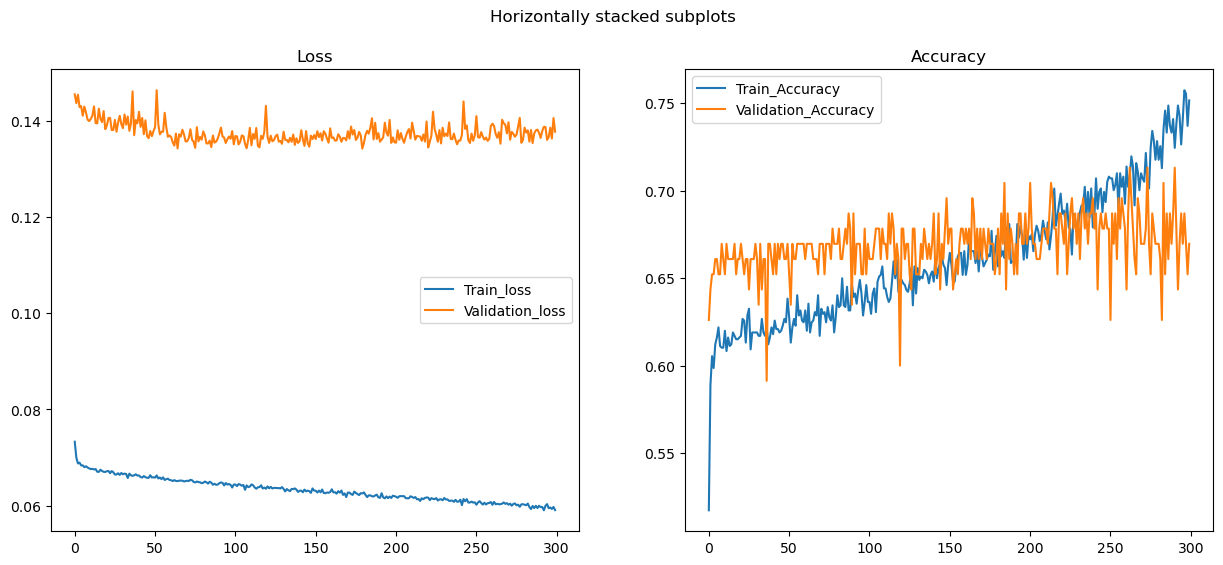

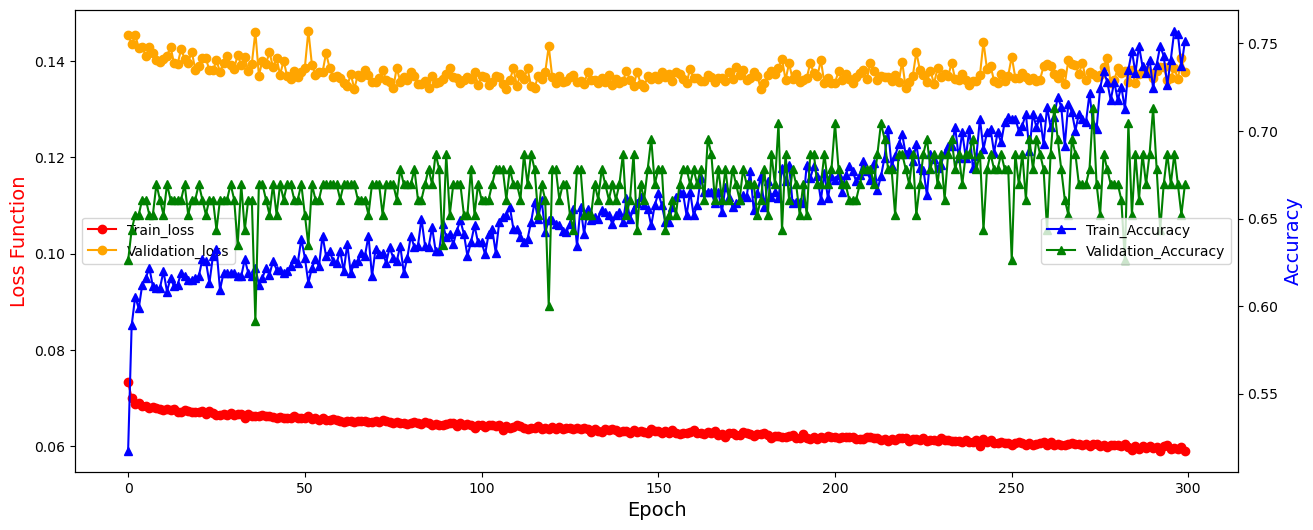

Current time: 98.060 minutes. Time expected till completion: 65.373 minutes

Epoch 301 of 500


100%|██████████| 15/15 [00:00<00:00, 16.19it/s]


train loss:  0.059328574968260536
Val loss:  0.13675349795300026
train accuracy:  0.7485493230174082
Val accuracy:  0.6608695652173913
Current time: 98.377 minutes. Time expected till completion: 65.040 minutes

Epoch 302 of 500


100%|██████████| 15/15 [00:00<00:00, 16.64it/s]


train loss:  0.059081779457844895
Val loss:  0.1408536532650823
train accuracy:  0.7514506769825918
Val accuracy:  0.6260869565217392
Current time: 98.686 minutes. Time expected till completion: 64.702 minutes

Epoch 303 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.05971406339676744
Val loss:  0.13697778504827748
train accuracy:  0.7437137330754352
Val accuracy:  0.6956521739130435
Current time: 98.997 minutes. Time expected till completion: 64.364 minutes

Epoch 304 of 500


100%|██████████| 15/15 [00:00<00:00, 17.11it/s]


train loss:  0.05941395550908618
Val loss:  0.13431012319481891
train accuracy:  0.7669245647969052
Val accuracy:  0.6782608695652174
Current time: 99.306 minutes. Time expected till completion: 64.026 minutes

Epoch 305 of 500


100%|██████████| 15/15 [00:00<00:00, 16.67it/s]


train loss:  0.059457723072926356
Val loss:  0.13675647144732267
train accuracy:  0.7427466150870407
Val accuracy:  0.6521739130434783
Current time: 99.617 minutes. Time expected till completion: 63.690 minutes

Epoch 306 of 500


100%|██████████| 15/15 [00:00<00:00, 17.11it/s]


train loss:  0.05976138026156324
Val loss:  0.13876555484274158
train accuracy:  0.7446808510638298
Val accuracy:  0.6608695652173913
Current time: 99.926 minutes. Time expected till completion: 63.352 minutes

Epoch 307 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.059352323499362286
Val loss:  0.146368162010027
train accuracy:  0.741779497098646
Val accuracy:  0.6260869565217392
Current time: 100.235 minutes. Time expected till completion: 63.014 minutes

Epoch 308 of 500


100%|██████████| 15/15 [00:00<00:00, 16.56it/s]


train loss:  0.06007332468632342
Val loss:  0.14070786859678186
train accuracy:  0.7369439071566731
Val accuracy:  0.6869565217391305
Current time: 100.547 minutes. Time expected till completion: 62.679 minutes

Epoch 309 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.05935685477819387
Val loss:  0.13610856533050536
train accuracy:  0.7475822050290135
Val accuracy:  0.6608695652173913
Current time: 100.857 minutes. Time expected till completion: 62.342 minutes

Epoch 310 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.05943115894291802
Val loss:  0.13981661019117936
train accuracy:  0.7340425531914894
Val accuracy:  0.6608695652173913
Current time: 101.168 minutes. Time expected till completion: 62.006 minutes

Epoch 311 of 500


100%|██████████| 15/15 [00:00<00:00, 16.62it/s]


train loss:  0.05931695725055451
Val loss:  0.13841509767200635
train accuracy:  0.7591876208897486
Val accuracy:  0.6782608695652174
Current time: 101.475 minutes. Time expected till completion: 61.668 minutes

Epoch 312 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.05917693677446598
Val loss:  0.13576363221458768
train accuracy:  0.7562862669245648
Val accuracy:  0.6869565217391305
Current time: 101.786 minutes. Time expected till completion: 61.332 minutes

Epoch 313 of 500


100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


train loss:  0.05952976935145011
Val loss:  0.13967730791672417
train accuracy:  0.7456479690522244
Val accuracy:  0.6608695652173913
Current time: 102.096 minutes. Time expected till completion: 60.996 minutes

Epoch 314 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.05942205367051425
Val loss:  0.13935318304144817
train accuracy:  0.753384912959381
Val accuracy:  0.6695652173913044
Current time: 102.406 minutes. Time expected till completion: 60.661 minutes

Epoch 315 of 500


100%|██████████| 15/15 [00:00<00:00, 16.67it/s]


train loss:  0.05938698106393132
Val loss:  0.13698278872863107
train accuracy:  0.7553191489361702
Val accuracy:  0.7217391304347827
Current time: 102.716 minutes. Time expected till completion: 60.325 minutes

Epoch 316 of 500


100%|██████████| 15/15 [00:00<00:00, 16.66it/s]


train loss:  0.0586465284718305
Val loss:  0.13957586340282274
train accuracy:  0.7649903288201161
Val accuracy:  0.6695652173913044
Current time: 103.027 minutes. Time expected till completion: 59.991 minutes

Epoch 317 of 500


100%|██████████| 15/15 [00:00<00:00, 16.84it/s]


train loss:  0.058775553043852465
Val loss:  0.13976078344428022
train accuracy:  0.7630560928433269
Val accuracy:  0.6695652173913044
Current time: 103.339 minutes. Time expected till completion: 59.657 minutes

Epoch 318 of 500


100%|██████████| 15/15 [00:00<00:00, 16.62it/s]


train loss:  0.059088520086019135
Val loss:  0.13933815541474714
train accuracy:  0.7707930367504836
Val accuracy:  0.6434782608695652
Current time: 103.650 minutes. Time expected till completion: 59.322 minutes

Epoch 319 of 500


100%|██████████| 15/15 [00:00<00:00, 16.49it/s]


train loss:  0.058972639952222426
Val loss:  0.1380079404167507
train accuracy:  0.7640232108317214
Val accuracy:  0.6347826086956522
Current time: 103.961 minutes. Time expected till completion: 58.987 minutes

Epoch 320 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.05871457754989196
Val loss:  0.137165019304856
train accuracy:  0.7736943907156673
Val accuracy:  0.7043478260869566
Current time: 104.270 minutes. Time expected till completion: 58.652 minutes

Epoch 321 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.05868632270012419
Val loss:  0.13942483819049337
train accuracy:  0.7640232108317214
Val accuracy:  0.6608695652173913
Current time: 104.580 minutes. Time expected till completion: 58.317 minutes

Epoch 322 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.05908312292578603
Val loss:  0.13727574452109959
train accuracy:  0.7649903288201161
Val accuracy:  0.6695652173913044
Current time: 104.889 minutes. Time expected till completion: 57.982 minutes

Epoch 323 of 500


100%|██████████| 15/15 [00:00<00:00, 16.73it/s]


train loss:  0.058905480908701915
Val loss:  0.13561870637147322
train accuracy:  0.7707930367504836
Val accuracy:  0.6782608695652174
Current time: 105.203 minutes. Time expected till completion: 57.650 minutes

Epoch 324 of 500


100%|██████████| 15/15 [00:00<00:00, 16.60it/s]


train loss:  0.059887487318806304
Val loss:  0.14128739004549773
train accuracy:  0.7437137330754352
Val accuracy:  0.6260869565217392
Current time: 105.513 minutes. Time expected till completion: 57.316 minutes

Epoch 325 of 500


100%|██████████| 15/15 [00:00<00:00, 16.56it/s]


train loss:  0.0591256184434983
Val loss:  0.1384426324263863
train accuracy:  0.753384912959381
Val accuracy:  0.6695652173913044
Current time: 105.822 minutes. Time expected till completion: 56.981 minutes

Epoch 326 of 500


100%|██████████| 15/15 [00:00<00:00, 16.69it/s]


train loss:  0.05884470815123626
Val loss:  0.1403623762338058
train accuracy:  0.7678916827852998
Val accuracy:  0.6521739130434783
Current time: 106.131 minutes. Time expected till completion: 56.647 minutes

Epoch 327 of 500


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


train loss:  0.058452338383783456
Val loss:  0.1383194757544476
train accuracy:  0.7736943907156673
Val accuracy:  0.6869565217391305
Current time: 106.441 minutes. Time expected till completion: 56.313 minutes

Epoch 328 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.05875549890547702
Val loss:  0.13874600348265276
train accuracy:  0.7746615087040619
Val accuracy:  0.6695652173913044
Current time: 106.752 minutes. Time expected till completion: 55.980 minutes

Epoch 329 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.05840667782484678
Val loss:  0.13541867733001708
train accuracy:  0.7852998065764023
Val accuracy:  0.6869565217391305
Current time: 107.067 minutes. Time expected till completion: 55.649 minutes

Epoch 330 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.058705474583277156
Val loss:  0.13620133348133254
train accuracy:  0.7707930367504836
Val accuracy:  0.6869565217391305
Current time: 107.382 minutes. Time expected till completion: 55.318 minutes

Epoch 331 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.05859868323549311
Val loss:  0.1390639154807381
train accuracy:  0.7678916827852998
Val accuracy:  0.6869565217391305
Current time: 107.693 minutes. Time expected till completion: 54.985 minutes

Epoch 332 of 500


100%|██████████| 15/15 [00:00<00:00, 16.49it/s]


train loss:  0.059215994706698034
Val loss:  0.13992402760878853
train accuracy:  0.7659574468085106
Val accuracy:  0.6347826086956522
Current time: 108.003 minutes. Time expected till completion: 54.652 minutes

Epoch 333 of 500


100%|██████████| 15/15 [00:00<00:00, 16.64it/s]


train loss:  0.05845103590124119
Val loss:  0.13923320718433546
train accuracy:  0.7833655705996132
Val accuracy:  0.6434782608695652
Current time: 108.315 minutes. Time expected till completion: 54.320 minutes

Epoch 334 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.05866681849241718
Val loss:  0.1399554262990537
train accuracy:  0.7736943907156673
Val accuracy:  0.6434782608695652
Current time: 108.634 minutes. Time expected till completion: 53.992 minutes

Epoch 335 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.05803705553021606
Val loss:  0.1382057433542998
train accuracy:  0.7833655705996132
Val accuracy:  0.6347826086956522
Current time: 108.944 minutes. Time expected till completion: 53.659 minutes

Epoch 336 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.0589677880534351
Val loss:  0.1398334881533747
train accuracy:  0.7678916827852998
Val accuracy:  0.6347826086956522
Current time: 109.256 minutes. Time expected till completion: 53.327 minutes

Epoch 337 of 500


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


train loss:  0.05887103461204691
Val loss:  0.1365070685096409
train accuracy:  0.7688588007736944
Val accuracy:  0.6956521739130435
Current time: 109.565 minutes. Time expected till completion: 52.994 minutes

Epoch 338 of 500


100%|██████████| 15/15 [00:00<00:00, 17.03it/s]


train loss:  0.058572319420901214
Val loss:  0.1415026535158572
train accuracy:  0.7707930367504836
Val accuracy:  0.6260869565217392
Current time: 109.876 minutes. Time expected till completion: 52.662 minutes

Epoch 339 of 500


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


train loss:  0.05819720923324157
Val loss:  0.1361021596452464
train accuracy:  0.7833655705996132
Val accuracy:  0.6695652173913044
Current time: 110.186 minutes. Time expected till completion: 52.330 minutes

Epoch 340 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.05926681810006413
Val loss:  0.1395814325498498
train accuracy:  0.7572533849129593
Val accuracy:  0.6521739130434783
Current time: 110.498 minutes. Time expected till completion: 51.999 minutes

Epoch 341 of 500


100%|██████████| 15/15 [00:00<00:00, 16.86it/s]


train loss:  0.05790963065693411
Val loss:  0.13918411939040473
train accuracy:  0.793036750483559
Val accuracy:  0.6869565217391305
Current time: 110.808 minutes. Time expected till completion: 51.667 minutes

Epoch 342 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.05852970054347926
Val loss:  0.13625393483949744
train accuracy:  0.7794970986460348
Val accuracy:  0.6260869565217392
Current time: 111.118 minutes. Time expected till completion: 51.335 minutes

Epoch 343 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.05805674927377608
Val loss:  0.1375602038010307
train accuracy:  0.7852998065764023
Val accuracy:  0.6608695652173913
Current time: 111.427 minutes. Time expected till completion: 51.003 minutes

Epoch 344 of 500


100%|██████████| 15/15 [00:00<00:00, 16.64it/s]


train loss:  0.05871701396180306
Val loss:  0.13647866404574852
train accuracy:  0.7911025145067698
Val accuracy:  0.6869565217391305
Current time: 111.738 minutes. Time expected till completion: 50.672 minutes

Epoch 345 of 500


100%|██████████| 15/15 [00:00<00:00, 17.67it/s]


train loss:  0.058231605033118215
Val loss:  0.14032942523127018
train accuracy:  0.776595744680851
Val accuracy:  0.6695652173913044
Current time: 112.050 minutes. Time expected till completion: 50.341 minutes

Epoch 346 of 500


100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


train loss:  0.058275395827782225
Val loss:  0.13581295376238617
train accuracy:  0.7891682785299806
Val accuracy:  0.6869565217391305
Current time: 112.362 minutes. Time expected till completion: 50.011 minutes

Epoch 347 of 500


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


train loss:  0.0581870168966297
Val loss:  0.1371713135553443
train accuracy:  0.8104448742746615
Val accuracy:  0.6695652173913044
Current time: 112.671 minutes. Time expected till completion: 49.679 minutes

Epoch 348 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.057840847992113066
Val loss:  0.13690350003864454
train accuracy:  0.7949709864603481
Val accuracy:  0.6347826086956522
Current time: 112.982 minutes. Time expected till completion: 49.349 minutes

Epoch 349 of 500


100%|██████████| 15/15 [00:00<00:00, 16.80it/s]


train loss:  0.05815795928643335
Val loss:  0.13981996981993966
train accuracy:  0.7872340425531915
Val accuracy:  0.6608695652173913
Current time: 113.291 minutes. Time expected till completion: 49.017 minutes

Epoch 350 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.058194663815157095
Val loss:  0.14081504500430564
train accuracy:  0.7882011605415861
Val accuracy:  0.6521739130434783
Current time: 113.601 minutes. Time expected till completion: 48.686 minutes

Epoch 351 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.057693458099199214
Val loss:  0.1393644623134447
train accuracy:  0.8075435203094777
Val accuracy:  0.6347826086956522
Current time: 113.910 minutes. Time expected till completion: 48.355 minutes

Epoch 352 of 500


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


train loss:  0.05821903686920033
Val loss:  0.13903314652650253
train accuracy:  0.7794970986460348
Val accuracy:  0.7043478260869566
Current time: 114.221 minutes. Time expected till completion: 48.025 minutes

Epoch 353 of 500


100%|██████████| 15/15 [00:00<00:00, 16.56it/s]


train loss:  0.057301435180051645
Val loss:  0.13999485503072323
train accuracy:  0.8085106382978723
Val accuracy:  0.6521739130434783
Current time: 114.532 minutes. Time expected till completion: 47.695 minutes

Epoch 354 of 500


100%|██████████| 15/15 [00:00<00:00, 17.11it/s]


train loss:  0.057819627585678546
Val loss:  0.13947508075962897
train accuracy:  0.8007736943907157
Val accuracy:  0.6347826086956522
Current time: 114.843 minutes. Time expected till completion: 47.365 minutes

Epoch 355 of 500


100%|██████████| 15/15 [00:00<00:00, 16.60it/s]


train loss:  0.05832778398718548
Val loss:  0.13925144827884176
train accuracy:  0.7891682785299806
Val accuracy:  0.6608695652173913
Current time: 115.152 minutes. Time expected till completion: 47.034 minutes

Epoch 356 of 500


100%|██████████| 15/15 [00:00<00:00, 16.69it/s]


train loss:  0.05749784631932035
Val loss:  0.1379453612410504
train accuracy:  0.793036750483559
Val accuracy:  0.6608695652173913
Current time: 115.460 minutes. Time expected till completion: 46.703 minutes

Epoch 357 of 500


100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


train loss:  0.05784725214803242
Val loss:  0.13621907234191893
train accuracy:  0.804642166344294
Val accuracy:  0.6695652173913044
Current time: 115.770 minutes. Time expected till completion: 46.373 minutes

Epoch 358 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.05758737964371879
Val loss:  0.13783032583153765
train accuracy:  0.8123791102514507
Val accuracy:  0.6434782608695652
Current time: 116.081 minutes. Time expected till completion: 46.043 minutes

Epoch 359 of 500


100%|██████████| 15/15 [00:00<00:00, 16.66it/s]


train loss:  0.05776311454274899
Val loss:  0.13723967800969664
train accuracy:  0.8036750483558994
Val accuracy:  0.6608695652173913
Current time: 116.394 minutes. Time expected till completion: 45.715 minutes

Epoch 360 of 500


100%|██████████| 15/15 [00:00<00:00, 17.67it/s]


train loss:  0.05800718570585638
Val loss:  0.13791194117587546
train accuracy:  0.7988394584139265
Val accuracy:  0.6608695652173913
Current time: 116.703 minutes. Time expected till completion: 45.385 minutes

Epoch 361 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.057449551800002906
Val loss:  0.1456418540166772
train accuracy:  0.8152804642166345
Val accuracy:  0.6521739130434783
Current time: 117.011 minutes. Time expected till completion: 45.054 minutes

Epoch 362 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.057428015039322225
Val loss:  0.13760337570439216
train accuracy:  0.8017408123791102
Val accuracy:  0.6347826086956522
Current time: 117.324 minutes. Time expected till completion: 44.726 minutes

Epoch 363 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.05789559779822019
Val loss:  0.13549510758856068
train accuracy:  0.793036750483559
Val accuracy:  0.6260869565217392
Current time: 117.637 minutes. Time expected till completion: 44.398 minutes

Epoch 364 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.05736819272806843
Val loss:  0.13750124599622643
train accuracy:  0.809477756286267
Val accuracy:  0.6869565217391305
Current time: 117.947 minutes. Time expected till completion: 44.068 minutes

Epoch 365 of 500


100%|██████████| 15/15 [00:00<00:00, 16.80it/s]


train loss:  0.057099593158386204
Val loss:  0.14058263664660248
train accuracy:  0.8172147001934236
Val accuracy:  0.6086956521739131
Current time: 118.261 minutes. Time expected till completion: 43.740 minutes

Epoch 366 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.05745288476030877
Val loss:  0.1403013421141583
train accuracy:  0.7978723404255319
Val accuracy:  0.6
Current time: 118.571 minutes. Time expected till completion: 43.411 minutes

Epoch 367 of 500


100%|██████████| 15/15 [00:00<00:00, 17.74it/s]


train loss:  0.05754118915683296
Val loss:  0.14169184332308563
train accuracy:  0.8075435203094777
Val accuracy:  0.6521739130434783
Current time: 118.880 minutes. Time expected till completion: 43.082 minutes

Epoch 368 of 500


100%|██████████| 15/15 [00:00<00:00, 17.67it/s]


train loss:  0.05686409463043139
Val loss:  0.1422028976937999
train accuracy:  0.8143133462282398
Val accuracy:  0.6347826086956522
Current time: 119.189 minutes. Time expected till completion: 42.753 minutes

Epoch 369 of 500


100%|██████████| 15/15 [00:00<00:00, 17.03it/s]


train loss:  0.057859169848882945
Val loss:  0.13580218346222586
train accuracy:  0.7940038684719536
Val accuracy:  0.6695652173913044
Current time: 119.499 minutes. Time expected till completion: 42.424 minutes

Epoch 370 of 500


100%|██████████| 15/15 [00:00<00:00, 17.03it/s]


train loss:  0.0567808382400461
Val loss:  0.13600900328677634
train accuracy:  0.8152804642166345
Val accuracy:  0.6521739130434783
Current time: 119.810 minutes. Time expected till completion: 42.095 minutes

Epoch 371 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.057148206741251845
Val loss:  0.14395801813706108
train accuracy:  0.8152804642166345
Val accuracy:  0.6086956521739131
Current time: 120.121 minutes. Time expected till completion: 41.767 minutes

Epoch 372 of 500


100%|██████████| 15/15 [00:00<00:00, 16.62it/s]


train loss:  0.05668463017539314
Val loss:  0.14092915783757748
train accuracy:  0.8220502901353965
Val accuracy:  0.6608695652173913
Current time: 120.430 minutes. Time expected till completion: 41.438 minutes

Epoch 373 of 500


100%|██████████| 15/15 [00:00<00:00, 17.67it/s]


train loss:  0.057556614135635197
Val loss:  0.1406355241070623
train accuracy:  0.8075435203094777
Val accuracy:  0.6
Current time: 120.741 minutes. Time expected till completion: 41.110 minutes

Epoch 374 of 500


100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


train loss:  0.05676073274022145
Val loss:  0.13895545524099598
train accuracy:  0.8297872340425532
Val accuracy:  0.6086956521739131
Current time: 121.050 minutes. Time expected till completion: 40.782 minutes

Epoch 375 of 500


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


train loss:  0.056270202827176916
Val loss:  0.14261802279430888
train accuracy:  0.8365570599613152
Val accuracy:  0.5739130434782609
Current time: 121.359 minutes. Time expected till completion: 40.453 minutes

Epoch 376 of 500


100%|██████████| 15/15 [00:00<00:00, 16.92it/s]


train loss:  0.05671427697231507
Val loss:  0.13862908041995506
train accuracy:  0.8307543520309478
Val accuracy:  0.6521739130434783
Current time: 121.670 minutes. Time expected till completion: 40.125 minutes

Epoch 377 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.05649789130203498
Val loss:  0.1391154284062593
train accuracy:  0.8288201160541586
Val accuracy:  0.6260869565217392
Current time: 121.981 minutes. Time expected till completion: 39.797 minutes

Epoch 378 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.057253706558991216
Val loss:  0.14284265352332073
train accuracy:  0.8075435203094777
Val accuracy:  0.5391304347826087
Current time: 122.289 minutes. Time expected till completion: 39.469 minutes

Epoch 379 of 500


100%|██████████| 15/15 [00:00<00:00, 16.49it/s]


train loss:  0.05757667536431171
Val loss:  0.13514946180841197
train accuracy:  0.8152804642166345
Val accuracy:  0.6260869565217392
Current time: 122.600 minutes. Time expected till completion: 39.142 minutes

Epoch 380 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.056409556180872816
Val loss:  0.137746566793193
train accuracy:  0.8268858800773694
Val accuracy:  0.6347826086956522
Current time: 122.910 minutes. Time expected till completion: 38.814 minutes

Epoch 381 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.05754468640460267
Val loss:  0.14027892869451772
train accuracy:  0.793036750483559
Val accuracy:  0.6
Current time: 123.221 minutes. Time expected till completion: 38.486 minutes

Epoch 382 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.056498671177508064
Val loss:  0.14379918212475984
train accuracy:  0.8317214700193424
Val accuracy:  0.6173913043478261
Current time: 123.530 minutes. Time expected till completion: 38.158 minutes

Epoch 383 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.05666085904755952
Val loss:  0.14138305239055468
train accuracy:  0.8230174081237911
Val accuracy:  0.6086956521739131
Current time: 123.841 minutes. Time expected till completion: 37.831 minutes

Epoch 384 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.056740705118419124
Val loss:  0.13855082988739015
train accuracy:  0.8181818181818182
Val accuracy:  0.6260869565217392
Current time: 124.154 minutes. Time expected till completion: 37.505 minutes

Epoch 385 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.055983045633803026
Val loss:  0.1450748754584271
train accuracy:  0.8336557059961315
Val accuracy:  0.6086956521739131
Current time: 124.486 minutes. Time expected till completion: 37.184 minutes

Epoch 386 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.05615903929999995
Val loss:  0.14000846354857735
train accuracy:  0.8452611218568665
Val accuracy:  0.6260869565217392
Current time: 124.798 minutes. Time expected till completion: 36.858 minutes

Epoch 387 of 500


100%|██████████| 15/15 [00:00<00:00, 16.66it/s]


train loss:  0.05641555238507933
Val loss:  0.14443948839021767
train accuracy:  0.8278529980657641
Val accuracy:  0.6173913043478261
Current time: 125.111 minutes. Time expected till completion: 36.531 minutes

Epoch 388 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.05707339461121845
Val loss:  0.13832969717357468
train accuracy:  0.8143133462282398
Val accuracy:  0.6347826086956522
Current time: 125.425 minutes. Time expected till completion: 36.205 minutes

Epoch 389 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.05662718265384032
Val loss:  0.13495491950408273
train accuracy:  0.8326885880077369
Val accuracy:  0.6695652173913044
Current time: 125.739 minutes. Time expected till completion: 35.879 minutes

Epoch 390 of 500


100%|██████████| 15/15 [00:00<00:00, 16.22it/s]


train loss:  0.05576293882364461
Val loss:  0.14234887361526488
train accuracy:  0.839458413926499
Val accuracy:  0.6260869565217392
Current time: 126.053 minutes. Time expected till completion: 35.553 minutes

Epoch 391 of 500


100%|██████████| 15/15 [00:00<00:00, 16.66it/s]


train loss:  0.056747537747573115
Val loss:  0.14262063451435256
train accuracy:  0.8259187620889749
Val accuracy:  0.6
Current time: 126.364 minutes. Time expected till completion: 35.227 minutes

Epoch 392 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.05541155139989502
Val loss:  0.14271689031435095
train accuracy:  0.8462282398452611
Val accuracy:  0.6347826086956522
Current time: 126.682 minutes. Time expected till completion: 34.902 minutes

Epoch 393 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.05605485954644371
Val loss:  0.1412740303122479
train accuracy:  0.8326885880077369
Val accuracy:  0.6
Current time: 126.993 minutes. Time expected till completion: 34.576 minutes

Epoch 394 of 500


100%|██████████| 15/15 [00:00<00:00, 16.96it/s]


train loss:  0.05604958534240723
Val loss:  0.14384365496428117
train accuracy:  0.8355899419729207
Val accuracy:  0.6173913043478261
Current time: 127.307 minutes. Time expected till completion: 34.250 minutes

Epoch 395 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.05666350401808261
Val loss:  0.14129374597383582
train accuracy:  0.8220502901353965
Val accuracy:  0.5826086956521739
Current time: 127.620 minutes. Time expected till completion: 33.924 minutes

Epoch 396 of 500


100%|██████████| 15/15 [00:00<00:00, 17.11it/s]


train loss:  0.056653142436560625
Val loss:  0.14178056354108065
train accuracy:  0.8288201160541586
Val accuracy:  0.6260869565217392
Current time: 127.931 minutes. Time expected till completion: 33.598 minutes

Epoch 397 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.05546404262806507
Val loss:  0.14362066414045252
train accuracy:  0.8481624758220503
Val accuracy:  0.5826086956521739
Current time: 128.247 minutes. Time expected till completion: 33.273 minutes

Epoch 398 of 500


100%|██████████| 15/15 [00:00<00:00, 16.37it/s]


train loss:  0.056318951068118184
Val loss:  0.13610732710879783
train accuracy:  0.8249516441005803
Val accuracy:  0.6347826086956522
Current time: 128.559 minutes. Time expected till completion: 32.947 minutes

Epoch 399 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.05621185875722933
Val loss:  0.13909248424612958
train accuracy:  0.8230174081237911
Val accuracy:  0.6173913043478261
Current time: 128.873 minutes. Time expected till completion: 32.622 minutes

Epoch 400 of 500


100%|██████████| 15/15 [00:00<00:00, 15.75it/s]


train loss:  0.05596858954752437
Val loss:  0.138563871383667
train accuracy:  0.8404255319148937
Val accuracy:  0.6782608695652174
Saving model checkpoint


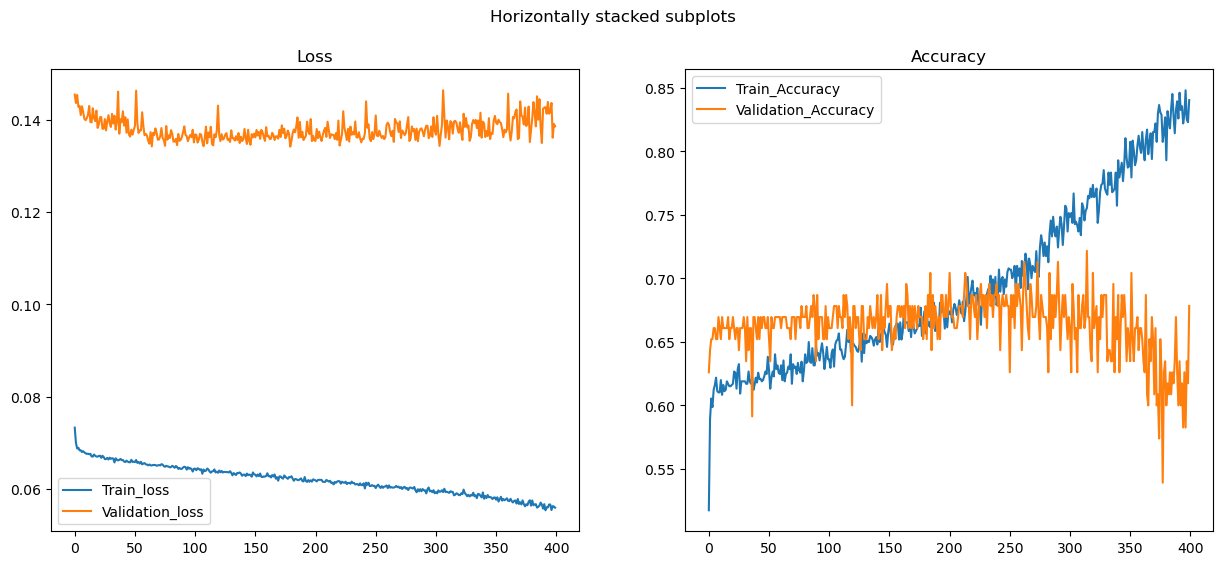

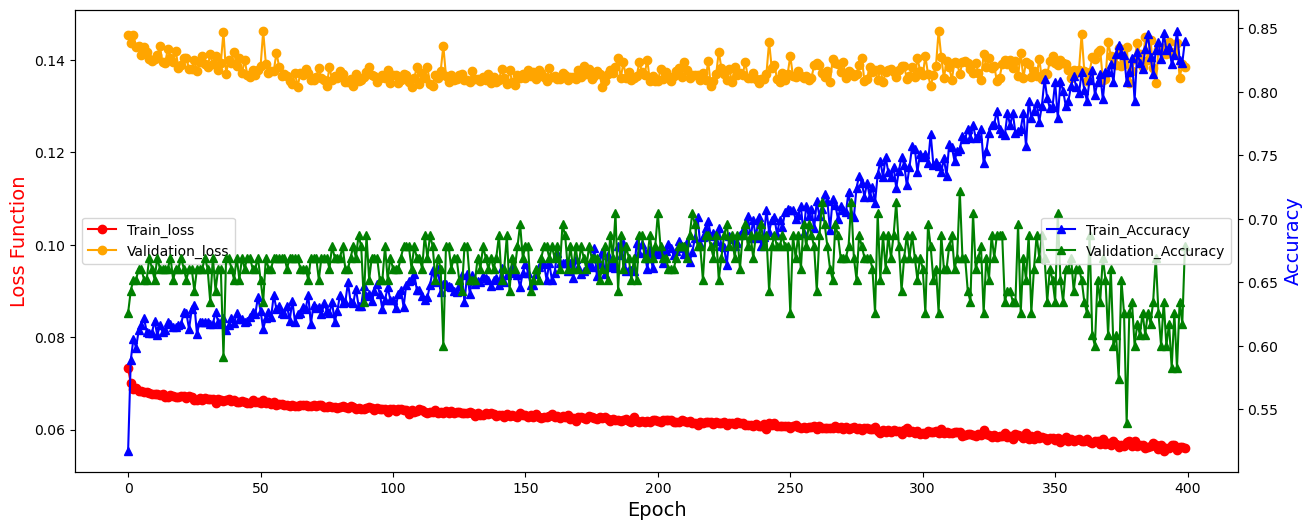

Current time: 129.201 minutes. Time expected till completion: 32.300 minutes

Epoch 401 of 500


100%|██████████| 15/15 [00:00<00:00, 16.24it/s]


train loss:  0.05555920962899981
Val loss:  0.13984704328619915
train accuracy:  0.8355899419729207
Val accuracy:  0.6434782608695652
Current time: 129.516 minutes. Time expected till completion: 31.975 minutes

Epoch 402 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.05577636433754484
Val loss:  0.13960458195727804
train accuracy:  0.8481624758220503
Val accuracy:  0.5826086956521739
Current time: 129.830 minutes. Time expected till completion: 31.650 minutes

Epoch 403 of 500


100%|██████████| 15/15 [00:00<00:00, 16.73it/s]


train loss:  0.05601477104183322
Val loss:  0.13868871408960093
train accuracy:  0.8307543520309478
Val accuracy:  0.6260869565217392
Current time: 130.142 minutes. Time expected till completion: 31.325 minutes

Epoch 404 of 500


100%|██████████| 15/15 [00:00<00:00, 16.98it/s]


train loss:  0.056321682448082784
Val loss:  0.1453198588412741
train accuracy:  0.8326885880077369
Val accuracy:  0.5565217391304348
Current time: 130.460 minutes. Time expected till completion: 31.000 minutes

Epoch 405 of 500


100%|██████████| 15/15 [00:00<00:00, 16.73it/s]


train loss:  0.0565286258549017
Val loss:  0.1369871611180513
train accuracy:  0.8172147001934236
Val accuracy:  0.6086956521739131
Current time: 130.773 minutes. Time expected till completion: 30.675 minutes

Epoch 406 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.055519613871491395
Val loss:  0.1420546987782354
train accuracy:  0.844294003868472
Val accuracy:  0.591304347826087
Current time: 131.088 minutes. Time expected till completion: 30.350 minutes

Epoch 407 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.05534817742425192
Val loss:  0.1394473480141681
train accuracy:  0.8539651837524178
Val accuracy:  0.6
Current time: 131.402 minutes. Time expected till completion: 30.025 minutes

Epoch 408 of 500


100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


train loss:  0.05586083253532129
Val loss:  0.13873660719912986
train accuracy:  0.8278529980657641
Val accuracy:  0.6434782608695652
Current time: 131.716 minutes. Time expected till completion: 29.701 minutes

Epoch 409 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.056060923310266936
Val loss:  0.14675849365151447
train accuracy:  0.8326885880077369
Val accuracy:  0.5739130434782609
Current time: 132.029 minutes. Time expected till completion: 29.376 minutes

Epoch 410 of 500


100%|██████████| 15/15 [00:00<00:00, 15.97it/s]


train loss:  0.056201413072054805
Val loss:  0.14612564314966617
train accuracy:  0.839458413926499
Val accuracy:  0.591304347826087
Current time: 132.342 minutes. Time expected till completion: 29.051 minutes

Epoch 411 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.055370981619482576
Val loss:  0.14143644312153691
train accuracy:  0.8539651837524178
Val accuracy:  0.5652173913043478
Current time: 132.655 minutes. Time expected till completion: 28.726 minutes

Epoch 412 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.05494467813226194
Val loss:  0.14460304923679518
train accuracy:  0.8558994197292069
Val accuracy:  0.5826086956521739
Current time: 132.976 minutes. Time expected till completion: 28.403 minutes

Epoch 413 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.05478749330546455
Val loss:  0.13716421645620594
train accuracy:  0.8655705996131529
Val accuracy:  0.6782608695652174
Current time: 133.289 minutes. Time expected till completion: 28.078 minutes

Epoch 414 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.05519114414543432
Val loss:  0.1419550527697024
train accuracy:  0.8491295938104448
Val accuracy:  0.591304347826087
Current time: 133.608 minutes. Time expected till completion: 27.754 minutes

Epoch 415 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.05535498105810966
Val loss:  0.13991052793419878
train accuracy:  0.8520309477756286
Val accuracy:  0.6521739130434783
Current time: 133.935 minutes. Time expected till completion: 27.433 minutes

Epoch 416 of 500


100%|██████████| 15/15 [00:00<00:00, 15.92it/s]


train loss:  0.05509379702103207
Val loss:  0.13932262814563254
train accuracy:  0.8607350096711799
Val accuracy:  0.6608695652173913
Current time: 134.250 minutes. Time expected till completion: 27.108 minutes

Epoch 417 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.05491289617475735
Val loss:  0.14267911600029987
train accuracy:  0.8568665377176016
Val accuracy:  0.6260869565217392
Current time: 134.563 minutes. Time expected till completion: 26.784 minutes

Epoch 418 of 500


100%|██████████| 15/15 [00:00<00:00, 16.84it/s]


train loss:  0.05544788244845097
Val loss:  0.13936230929001517
train accuracy:  0.844294003868472
Val accuracy:  0.6260869565217392
Current time: 134.876 minutes. Time expected till completion: 26.459 minutes

Epoch 419 of 500


100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


train loss:  0.05555616621814337
Val loss:  0.13946955152179885
train accuracy:  0.8452611218568665
Val accuracy:  0.6260869565217392
Current time: 135.186 minutes. Time expected till completion: 26.134 minutes

Epoch 420 of 500


100%|██████████| 15/15 [00:00<00:00, 16.66it/s]


train loss:  0.055433017430499165
Val loss:  0.13979559463003408
train accuracy:  0.8404255319148937
Val accuracy:  0.6086956521739131
Current time: 135.496 minutes. Time expected till completion: 25.809 minutes

Epoch 421 of 500


100%|██████████| 15/15 [00:00<00:00, 15.87it/s]


train loss:  0.05497474856026168
Val loss:  0.1401290846907574
train accuracy:  0.8558994197292069
Val accuracy:  0.6347826086956522
Current time: 135.815 minutes. Time expected till completion: 25.486 minutes

Epoch 422 of 500


100%|██████████| 15/15 [00:00<00:00, 17.03it/s]


train loss:  0.055286981439221526
Val loss:  0.14501648571180262
train accuracy:  0.8568665377176016
Val accuracy:  0.5826086956521739
Current time: 136.132 minutes. Time expected till completion: 25.162 minutes

Epoch 423 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.05530614035503085
Val loss:  0.145448534903319
train accuracy:  0.8549323017408124
Val accuracy:  0.5739130434782609
Current time: 136.446 minutes. Time expected till completion: 24.838 minutes

Epoch 424 of 500


100%|██████████| 15/15 [00:00<00:00, 16.17it/s]


train loss:  0.05618005541353207
Val loss:  0.14025537449380626
train accuracy:  0.8259187620889749
Val accuracy:  0.591304347826087
Current time: 136.758 minutes. Time expected till completion: 24.513 minutes

Epoch 425 of 500


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


train loss:  0.05454901956036197
Val loss:  0.13666686182436735
train accuracy:  0.8733075435203095
Val accuracy:  0.6260869565217392
Current time: 137.071 minutes. Time expected till completion: 24.189 minutes

Epoch 426 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.054318354427238036
Val loss:  0.14349636046782785
train accuracy:  0.8704061895551257
Val accuracy:  0.6347826086956522
Current time: 137.385 minutes. Time expected till completion: 23.865 minutes

Epoch 427 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.05552612645713688
Val loss:  0.13911973808122718
train accuracy:  0.8404255319148937
Val accuracy:  0.6
Current time: 137.699 minutes. Time expected till completion: 23.541 minutes

Epoch 428 of 500


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


train loss:  0.05495553563134583
Val loss:  0.14063615021498307
train accuracy:  0.8646034816247582
Val accuracy:  0.6
Current time: 138.017 minutes. Time expected till completion: 23.218 minutes

Epoch 429 of 500


100%|██████████| 15/15 [00:00<00:00, 16.56it/s]


train loss:  0.05555415574309904
Val loss:  0.1382853818976361
train accuracy:  0.8413926499032882
Val accuracy:  0.6695652173913044
Current time: 138.333 minutes. Time expected till completion: 22.894 minutes

Epoch 430 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.05531241106341379
Val loss:  0.14110261098198268
train accuracy:  0.8491295938104448
Val accuracy:  0.6260869565217392
Current time: 138.645 minutes. Time expected till completion: 22.570 minutes

Epoch 431 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.05502680065092312
Val loss:  0.13790690276933754
train accuracy:  0.8617021276595744
Val accuracy:  0.6347826086956522
Current time: 138.958 minutes. Time expected till completion: 22.246 minutes

Epoch 432 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.055164525195293315
Val loss:  0.14179501326187796
train accuracy:  0.8539651837524178
Val accuracy:  0.5739130434782609
Current time: 139.271 minutes. Time expected till completion: 21.922 minutes

Epoch 433 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.054561838248251025
Val loss:  0.13739700317382814
train accuracy:  0.8597678916827853
Val accuracy:  0.6434782608695652
Current time: 139.590 minutes. Time expected till completion: 21.599 minutes

Epoch 434 of 500


100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


train loss:  0.05415447255167786
Val loss:  0.14681416594463845
train accuracy:  0.8713733075435203
Val accuracy:  0.5739130434782609
Current time: 139.905 minutes. Time expected till completion: 21.276 minutes

Epoch 435 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.05441245771007796
Val loss:  0.14110400521236918
train accuracy:  0.8665377176015474
Val accuracy:  0.6086956521739131
Current time: 140.218 minutes. Time expected till completion: 20.952 minutes

Epoch 436 of 500


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


train loss:  0.055281403389844025
Val loss:  0.13830075885938561
train accuracy:  0.8481624758220503
Val accuracy:  0.6434782608695652
Current time: 140.532 minutes. Time expected till completion: 20.629 minutes

Epoch 437 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.054388139649101566
Val loss:  0.14188640843267025
train accuracy:  0.8694390715667312
Val accuracy:  0.6260869565217392
Current time: 140.844 minutes. Time expected till completion: 20.305 minutes

Epoch 438 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.05500141864127301
Val loss:  0.13605678910794466
train accuracy:  0.8626692456479691
Val accuracy:  0.6695652173913044
Current time: 141.159 minutes. Time expected till completion: 19.981 minutes

Epoch 439 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.05397168545473936
Val loss:  0.13823993050533792
train accuracy:  0.8858800773694391
Val accuracy:  0.6434782608695652
Current time: 141.474 minutes. Time expected till completion: 19.658 minutes

Epoch 440 of 500


100%|██████████| 15/15 [00:00<00:00, 16.45it/s]


train loss:  0.055103790022187814
Val loss:  0.13988734120907992
train accuracy:  0.8549323017408124
Val accuracy:  0.6260869565217392
Current time: 141.788 minutes. Time expected till completion: 19.335 minutes

Epoch 441 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.05467558460493844
Val loss:  0.1376063346862793
train accuracy:  0.8665377176015474
Val accuracy:  0.6434782608695652
Current time: 142.101 minutes. Time expected till completion: 19.011 minutes

Epoch 442 of 500


100%|██████████| 15/15 [00:00<00:00, 16.92it/s]


train loss:  0.05382906082059244
Val loss:  0.13994408897731614
train accuracy:  0.8868471953578336
Val accuracy:  0.6347826086956522
Current time: 142.415 minutes. Time expected till completion: 18.688 minutes

Epoch 443 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.0543735159896098
Val loss:  0.13853068662726362
train accuracy:  0.8655705996131529
Val accuracy:  0.5826086956521739
Current time: 142.730 minutes. Time expected till completion: 18.365 minutes

Epoch 444 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.05431643335916087
Val loss:  0.1406577353892119
train accuracy:  0.8655705996131529
Val accuracy:  0.6608695652173913
Current time: 143.045 minutes. Time expected till completion: 18.042 minutes

Epoch 445 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.05437336144410434
Val loss:  0.13848101159800655
train accuracy:  0.8588007736943907
Val accuracy:  0.6695652173913044
Current time: 143.359 minutes. Time expected till completion: 17.719 minutes

Epoch 446 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.05358153581619263
Val loss:  0.13874203744141952
train accuracy:  0.8907156673114119
Val accuracy:  0.6
Current time: 143.678 minutes. Time expected till completion: 17.396 minutes

Epoch 447 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.05412166688151701
Val loss:  0.14162723396135413
train accuracy:  0.874274661508704
Val accuracy:  0.6173913043478261
Current time: 143.994 minutes. Time expected till completion: 17.073 minutes

Epoch 448 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.0548428359875596
Val loss:  0.13795291600020035
train accuracy:  0.8646034816247582
Val accuracy:  0.6173913043478261
Current time: 144.307 minutes. Time expected till completion: 16.750 minutes

Epoch 449 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.054058459441481986
Val loss:  0.1460650869037794
train accuracy:  0.8723404255319149
Val accuracy:  0.5826086956521739
Current time: 144.621 minutes. Time expected till completion: 16.427 minutes

Epoch 450 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.05431622445468054
Val loss:  0.143947522536568
train accuracy:  0.8752417794970987
Val accuracy:  0.6086956521739131
Current time: 144.937 minutes. Time expected till completion: 16.104 minutes

Epoch 451 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.0538112065778249
Val loss:  0.1454603101896203
train accuracy:  0.8839458413926499
Val accuracy:  0.6260869565217392
Current time: 145.258 minutes. Time expected till completion: 15.782 minutes

Epoch 452 of 500


100%|██████████| 15/15 [00:00<00:00, 16.75it/s]


train loss:  0.05440743541348603
Val loss:  0.1449481285136679
train accuracy:  0.8626692456479691
Val accuracy:  0.591304347826087
Current time: 145.576 minutes. Time expected till completion: 15.459 minutes

Epoch 453 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.053981450009853285
Val loss:  0.14691107843233192
train accuracy:  0.8655705996131529
Val accuracy:  0.591304347826087
Current time: 145.890 minutes. Time expected till completion: 15.136 minutes

Epoch 454 of 500


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


train loss:  0.054169332035736144
Val loss:  0.14293050092199575
train accuracy:  0.8723404255319149
Val accuracy:  0.5826086956521739
Current time: 146.205 minutes. Time expected till completion: 14.814 minutes

Epoch 455 of 500


100%|██████████| 15/15 [00:00<00:00, 16.37it/s]


train loss:  0.05409768488928243
Val loss:  0.1423122245332469
train accuracy:  0.8829787234042553
Val accuracy:  0.6086956521739131
Current time: 146.520 minutes. Time expected till completion: 14.491 minutes

Epoch 456 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.05384645159977778
Val loss:  0.14153994632803876
train accuracy:  0.8771760154738878
Val accuracy:  0.6260869565217392
Current time: 146.834 minutes. Time expected till completion: 14.168 minutes

Epoch 457 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.053683107837717584
Val loss:  0.1394010507542154
train accuracy:  0.8810444874274661
Val accuracy:  0.591304347826087
Current time: 147.189 minutes. Time expected till completion: 13.849 minutes

Epoch 458 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.05447537289136153
Val loss:  0.14009314568146417
train accuracy:  0.8713733075435203
Val accuracy:  0.6260869565217392
Current time: 147.505 minutes. Time expected till completion: 13.527 minutes

Epoch 459 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.0532131649885233
Val loss:  0.1387965502946273
train accuracy:  0.8936170212765957
Val accuracy:  0.6434782608695652
Current time: 147.820 minutes. Time expected till completion: 13.204 minutes

Epoch 460 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.05416850483394453
Val loss:  0.14742573292359062
train accuracy:  0.867504835589942
Val accuracy:  0.5565217391304348
Current time: 148.137 minutes. Time expected till completion: 12.881 minutes

Epoch 461 of 500


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


train loss:  0.053763984077442546
Val loss:  0.14281099412752235
train accuracy:  0.8820116054158608
Val accuracy:  0.6173913043478261
Current time: 148.451 minutes. Time expected till completion: 12.559 minutes

Epoch 462 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.05413465804242073
Val loss:  0.13859078573144
train accuracy:  0.8733075435203095
Val accuracy:  0.6347826086956522
Current time: 148.769 minutes. Time expected till completion: 12.236 minutes

Epoch 463 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.05436715950587732
Val loss:  0.14732015910355942
train accuracy:  0.8733075435203095
Val accuracy:  0.5739130434782609
Current time: 149.083 minutes. Time expected till completion: 11.914 minutes

Epoch 464 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.05375617016214928
Val loss:  0.14345130972240283
train accuracy:  0.8771760154738878
Val accuracy:  0.5739130434782609
Current time: 149.397 minutes. Time expected till completion: 11.591 minutes

Epoch 465 of 500


100%|██████████| 15/15 [00:00<00:00, 15.87it/s]


train loss:  0.05391072062505283
Val loss:  0.14312002555183742
train accuracy:  0.8839458413926499
Val accuracy:  0.6260869565217392
Current time: 149.713 minutes. Time expected till completion: 11.269 minutes

Epoch 466 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.053588735296371134
Val loss:  0.13881215530893076
train accuracy:  0.8829787234042553
Val accuracy:  0.6434782608695652
Current time: 150.028 minutes. Time expected till completion: 10.946 minutes

Epoch 467 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.053530614887953264
Val loss:  0.14063729255095772
train accuracy:  0.8878143133462283
Val accuracy:  0.6260869565217392
Current time: 150.343 minutes. Time expected till completion: 10.624 minutes

Epoch 468 of 500


100%|██████████| 15/15 [00:00<00:00, 16.69it/s]


train loss:  0.053429542530897274
Val loss:  0.1426369273144266
train accuracy:  0.8926499032882012
Val accuracy:  0.6347826086956522
Current time: 150.655 minutes. Time expected till completion: 10.301 minutes

Epoch 469 of 500


100%|██████████| 15/15 [00:00<00:00, 16.88it/s]


train loss:  0.05372684473456451
Val loss:  0.14305047937061477
train accuracy:  0.8810444874274661
Val accuracy:  0.5826086956521739
Current time: 150.970 minutes. Time expected till completion: 9.979 minutes

Epoch 470 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.053591955157728216
Val loss:  0.13682849562686422
train accuracy:  0.8858800773694391
Val accuracy:  0.6608695652173913
Current time: 151.283 minutes. Time expected till completion: 9.656 minutes

Epoch 471 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.05341814403607721
Val loss:  0.14042317815448926
train accuracy:  0.8868471953578336
Val accuracy:  0.6347826086956522
Current time: 151.600 minutes. Time expected till completion: 9.334 minutes

Epoch 472 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.05311715989094408
Val loss:  0.14305071260618127
train accuracy:  0.8916827852998066
Val accuracy:  0.6086956521739131
Current time: 151.915 minutes. Time expected till completion: 9.012 minutes

Epoch 473 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.05447482543941623
Val loss:  0.13782277003578516
train accuracy:  0.874274661508704
Val accuracy:  0.6347826086956522
Current time: 152.230 minutes. Time expected till completion: 8.690 minutes

Epoch 474 of 500


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


train loss:  0.053999312092303305
Val loss:  0.14201661762983903
train accuracy:  0.8781431334622823
Val accuracy:  0.6086956521739131
Current time: 152.545 minutes. Time expected till completion: 8.367 minutes

Epoch 475 of 500


100%|██████████| 15/15 [00:00<00:00, 16.84it/s]


train loss:  0.05392613153854237
Val loss:  0.1393914538881053
train accuracy:  0.879110251450677
Val accuracy:  0.6434782608695652
Current time: 152.860 minutes. Time expected till completion: 8.045 minutes

Epoch 476 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.05453116387647632
Val loss:  0.14446430465449459
train accuracy:  0.8713733075435203
Val accuracy:  0.6086956521739131
Current time: 153.175 minutes. Time expected till completion: 7.723 minutes

Epoch 477 of 500


100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


train loss:  0.05447622424629256
Val loss:  0.1479486180388409
train accuracy:  0.8684719535783365
Val accuracy:  0.591304347826087
Current time: 153.493 minutes. Time expected till completion: 7.401 minutes

Epoch 478 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.053719081604273224
Val loss:  0.1422750498937524
train accuracy:  0.8820116054158608
Val accuracy:  0.6086956521739131
Current time: 153.809 minutes. Time expected till completion: 7.079 minutes

Epoch 479 of 500


100%|██████████| 15/15 [00:00<00:00, 16.64it/s]


train loss:  0.0534245745356355
Val loss:  0.13824870534565137
train accuracy:  0.8810444874274661
Val accuracy:  0.6521739130434783
Current time: 154.125 minutes. Time expected till completion: 6.757 minutes

Epoch 480 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.05309223171820723
Val loss:  0.13581757804621822
train accuracy:  0.8887814313346228
Val accuracy:  0.6608695652173913
Current time: 154.439 minutes. Time expected till completion: 6.435 minutes

Epoch 481 of 500


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


train loss:  0.05341640892988017
Val loss:  0.14169365945069687
train accuracy:  0.8897485493230174
Val accuracy:  0.6434782608695652
Current time: 154.752 minutes. Time expected till completion: 6.113 minutes

Epoch 482 of 500


100%|██████████| 15/15 [00:00<00:00, 16.69it/s]


train loss:  0.05397247564861807
Val loss:  0.14489414899245553
train accuracy:  0.879110251450677
Val accuracy:  0.5826086956521739
Current time: 155.066 minutes. Time expected till completion: 5.791 minutes

Epoch 483 of 500


100%|██████████| 15/15 [00:00<00:00, 16.53it/s]


train loss:  0.0533121014356152
Val loss:  0.13962306924488233
train accuracy:  0.8907156673114119
Val accuracy:  0.6347826086956522
Current time: 155.378 minutes. Time expected till completion: 5.469 minutes

Epoch 484 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.05313045726062251
Val loss:  0.14177217535350634
train accuracy:  0.8897485493230174
Val accuracy:  0.6
Current time: 155.691 minutes. Time expected till completion: 5.147 minutes

Epoch 485 of 500


100%|██████████| 15/15 [00:00<00:00, 16.62it/s]


train loss:  0.053251100289752454
Val loss:  0.14085274312807167
train accuracy:  0.8916827852998066
Val accuracy:  0.6347826086956522
Current time: 156.004 minutes. Time expected till completion: 4.825 minutes

Epoch 486 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.053542269671216926
Val loss:  0.1376131648602693
train accuracy:  0.8820116054158608
Val accuracy:  0.6434782608695652
Current time: 156.319 minutes. Time expected till completion: 4.503 minutes

Epoch 487 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.05332597300439093
Val loss:  0.14057538353878518
train accuracy:  0.8849129593810445
Val accuracy:  0.6347826086956522
Current time: 156.636 minutes. Time expected till completion: 4.181 minutes

Epoch 488 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.05298099221528384
Val loss:  0.14063325809395832
train accuracy:  0.8974854932301741
Val accuracy:  0.6521739130434783
Current time: 156.950 minutes. Time expected till completion: 3.859 minutes

Epoch 489 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.05330200450102181
Val loss:  0.13481484496075175
train accuracy:  0.8829787234042553
Val accuracy:  0.6608695652173913
Current time: 157.264 minutes. Time expected till completion: 3.538 minutes

Epoch 490 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.053080457956232924
Val loss:  0.13730383489442907
train accuracy:  0.8984526112185687
Val accuracy:  0.6956521739130435
Current time: 157.578 minutes. Time expected till completion: 3.216 minutes

Epoch 491 of 500


100%|██████████| 15/15 [00:00<00:00, 16.24it/s]


train loss:  0.05285468588022937
Val loss:  0.14547995017922444
train accuracy:  0.8965183752417795
Val accuracy:  0.5826086956521739
Current time: 157.891 minutes. Time expected till completion: 2.894 minutes

Epoch 492 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.05261977169684331
Val loss:  0.14655456957609758
train accuracy:  0.9042553191489362
Val accuracy:  0.5826086956521739
Current time: 158.210 minutes. Time expected till completion: 2.573 minutes

Epoch 493 of 500


100%|██████████| 15/15 [00:00<00:00, 16.22it/s]


train loss:  0.053083579763914215
Val loss:  0.13996653245842974
train accuracy:  0.8936170212765957
Val accuracy:  0.6347826086956522
Current time: 158.524 minutes. Time expected till completion: 2.251 minutes

Epoch 494 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.053490241330181834
Val loss:  0.1387499109558437
train accuracy:  0.8829787234042553
Val accuracy:  0.6521739130434783
Current time: 158.838 minutes. Time expected till completion: 1.929 minutes

Epoch 495 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.052693242203566734
Val loss:  0.1378577771394149
train accuracy:  0.9013539651837524
Val accuracy:  0.6434782608695652
Current time: 159.151 minutes. Time expected till completion: 1.608 minutes

Epoch 496 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.052882633944775194
Val loss:  0.136416248653246
train accuracy:  0.8994197292069632
Val accuracy:  0.6695652173913044
Current time: 159.466 minutes. Time expected till completion: 1.286 minutes

Epoch 497 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.05330555605012167
Val loss:  0.1403040429820185
train accuracy:  0.8955512572533849
Val accuracy:  0.6
Current time: 159.777 minutes. Time expected till completion: 0.964 minutes

Epoch 498 of 500


100%|██████████| 15/15 [00:00<00:00, 16.15it/s]


train loss:  0.05290814017880585
Val loss:  0.14614868371383002
train accuracy:  0.8974854932301741
Val accuracy:  0.5826086956521739
Current time: 160.093 minutes. Time expected till completion: 0.643 minutes

Epoch 499 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.05264532433487691
Val loss:  0.13850606524426004
train accuracy:  0.8955512572533849
Val accuracy:  0.6695652173913044
Current time: 160.406 minutes. Time expected till completion: 0.321 minutes

Epoch 500 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.053298328727541394
Val loss:  0.14067530217378035
train accuracy:  0.8858800773694391
Val accuracy:  0.6434782608695652
Saving model checkpoint


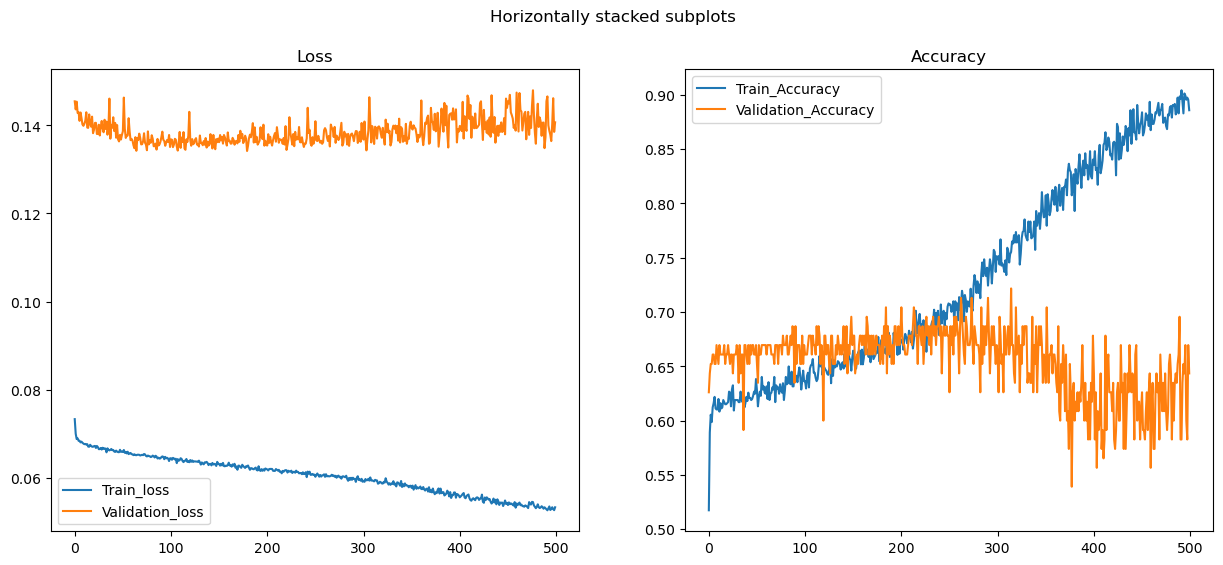

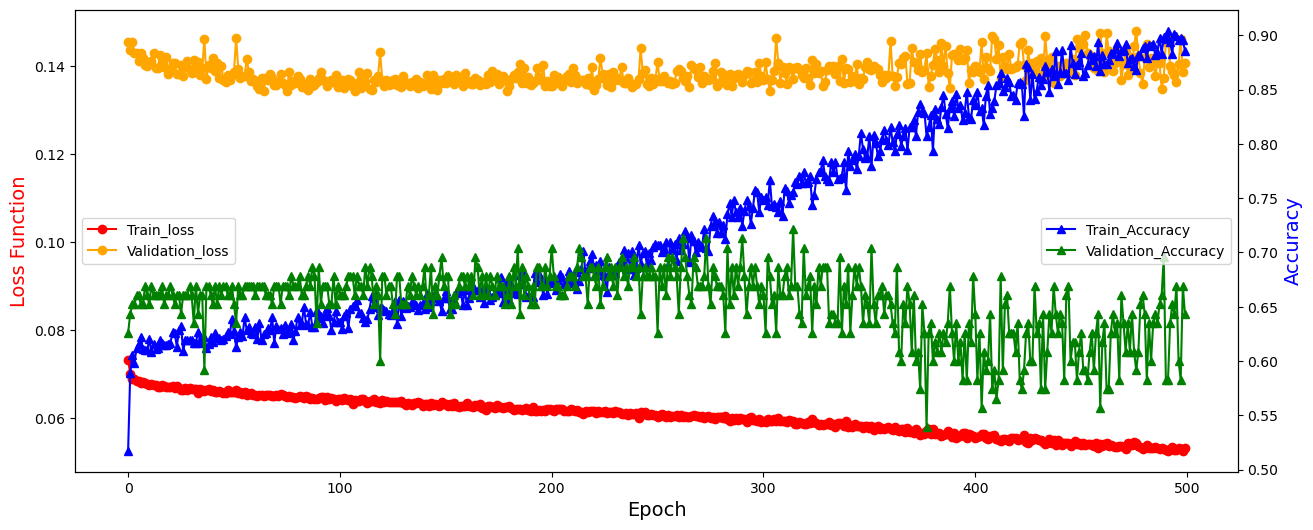

Current time: 160.827 minutes. Time expected till completion: 0.000 minutes
Finished training in: 160.827 minutes


In [15]:
#loader = train_loader # Use the train loader to train
#loader2 = valid_loader
# Main
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

val_loss_withDataAug, val_accuracy_withDataAug = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()
        
# count time
start = time.time()
#PyTorch - Training the Model
for epoch in range(epoch_check, epochs):
    print()
    # Print current epoch
    print(f"Epoch {epoch + 1} of {epochs}")
    
    # Train model
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # in pytorch you have assign the zero for gradien in any sub epoch
        #optim.zero_grad()
        #create the output from the CNN base on the give batch images
        out = modelpy(images)
        # count the loss function 
        loss = criterion(out, labels)
        
        ######################
        optim.zero_grad()#################
        ######################
        # count the backpropagation
        loss.backward()
        # learning
        optim.step()
        
        # add new value to the main loss
        running_loss += loss.item()
        
        # calculate accuracy
        predictions = torch.argmax(out, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total

    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)

    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        # Save Model
        print("Saving model checkpoint")
        end = time.time()
        time_elapsed = (end-start)+previous_time
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt_"+str(epoch+1)+".pth")
        
        # Cheack the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

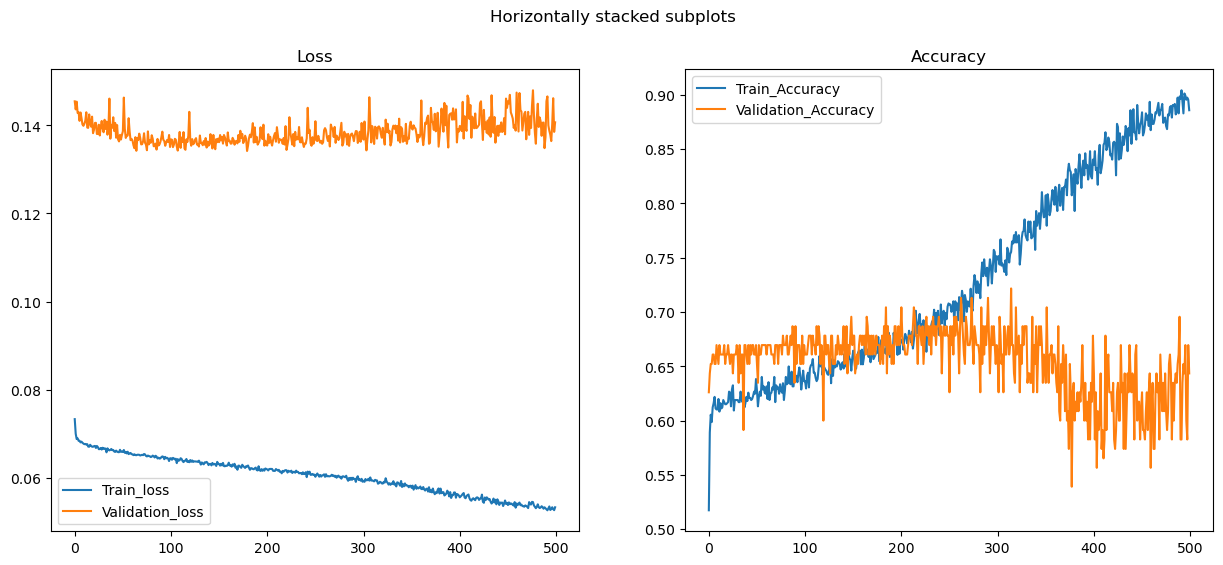

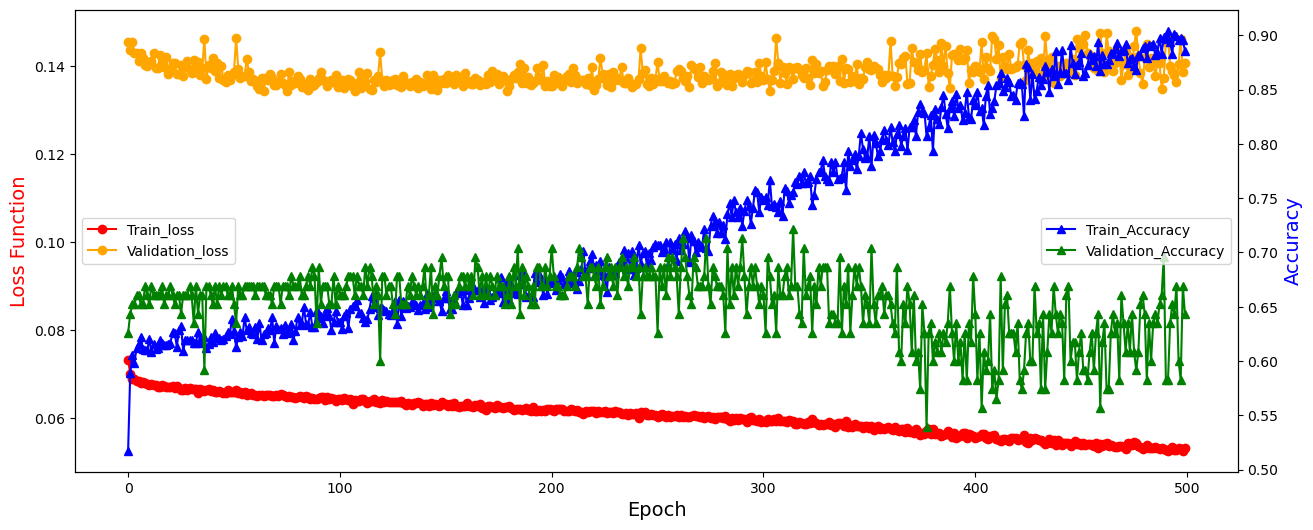

In [16]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

### Save Model

In [17]:
torch.save(modelpy.state_dict(), model_checkpoints + "saved_model_state_dict.pt")
torch.save(modelpy, model_checkpoints + "saved_model.pt")

# 3. Evaluate your model using the developed software

In [18]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

Accuracy of the network on the 1034 Train instances: 91.48936170212765%
Accuracy of the network on the 115 Validation instances: 64.34782608695652%


In [19]:
# Import the test dataset
size_of_resized_img = (224,224) 
test_data, test_names = import_test_folder_dataset_2(test_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", test_data.shape)
print("Dim of Lables: ", test_names.shape)

Dim of Data:  (380, 224, 224, 3)
Dim of Lables:  (380,)


In [20]:
# Create the dataset object
test_Dataset = Data_test_2(test_data, test_names, img_transform_val)#img_transform_val
print("Test len: ",len(test_Dataset))

Test len:  380


In [21]:
# Make the predictions for the test dataset
predictions_list, names = make_predictions(modelpy=modelpy, dataset=test_Dataset, device=device)
len(predictions_list)

380

In [22]:
# Save the Predictions
save_predictions_as_csv(names=names, predictions=predictions_list, name="05_8Conv_4Res_128FChannels_4Batch.csv")

# 4. Compare results with [SCTL paper](https://www.mdpi.com/2076-2615/12/7/886/htm). Requirement: performance is better than VGG16: 66.8%

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link here.

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points